![title](DensityOfStates.png)

<img src="DensityOfStates.png" alt="Alt text that describes the graphic" title="Title text" />
<p><cite>The Scream</cite> by Edward Munch. Painted in 1893.</p> 

# Import the libs

In [6]:
%pylab
import numpy as np
from scipy import integrate


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [7]:
%matplotlib inline

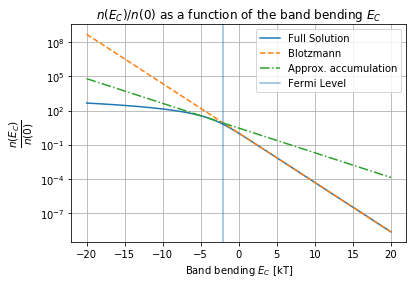

In [8]:
# -*- coding: utf-8 -*-
from Constants import *
import numpy as np
import scipy
from scipy.integrate import quad
from scipy.interpolate import interp1d
from functools import lru_cache
import numpy as np
import pandas as pd

    

class Material:
    def __init__(self,T_C,ND = 9e21, ED1C_eV = 0.034,ED2C_eV = 0.140, EPSILON = 9.86, mass_e_eff_factor =0.3, DIFF_EF_EC_evolt = 0.3):
        self.CONSTANTS = Constant()
        self.EPSILON = EPSILON
        self.MASS_E_EFF = mass_e_eff_factor*self.CONSTANTS.MASS_E
        self.T_C = T_C
        self.kT=self.CONSTANTS.kB*(self.CONSTANTS.K0+self.T_C)
        self.NC = 2*(2*np.pi*self.MASS_E_EFF*self.kT/(self.CONSTANTS.h**2))**(3.0/2.0)
        self.ND = ND
        self.ED1C = ED1C_eV
        self.ED2C = ED2C_eV
        if DIFF_EF_EC_evolt:
            self.Diff_EF_EC_evolt = DIFF_EF_EC_evolt
        else:
            self.Diff_EF_EC_evolt = self.calc_EDCF_by_temp()
        self.Diff_EF_EC=self.eV_to_J(self.Diff_EF_EC_evolt)
        self.Diff_VF_VC=self.Diff_EF_EC_evolt * self.CONSTANTS.E_CHARGE/self.kT
        #self.nb = self.NC*np.exp(-(self.Diff_EF_EC)/self.kT)
        self.nb, self.nb_err = self.n(0)
        self.LD = np.sqrt((self.EPSILON*self.CONSTANTS.EPSILON_0*self.kT)/(self.nb*(self.CONSTANTS.E_CHARGE**2)))
    
    def eV_to_J(self,eV):
        return eV*self.CONSTANTS.E_CHARGE
    
    def J_to_eV(self,J):
        return J/self.CONSTANTS.E_CHARGE
    
    def J_to_kT(self,J):
        return J/self.kT
    
    def kT_to_J(self,E_kT):
        return E_kT*self.kT

    def calc_EDCF_by_temp(self):
        #ND = 9e21 # 9*10**15 cm**3 Mich Thesis Seite 50
            
        a = np.exp(self.eV_to_J(self.ED1C)/self.kT)
        b = np.exp(self.eV_to_J(self.ED2C)/self.kT)
        
        
        t3 = 1.0
        t2 = (1.0/b-0.5*self.NC/self.ND)
        t1 = -1.0/b*self.NC/self.ND
        c = -1.0/(2*a*b)*self.NC/self.ND
        
        poly_params = (c,t1, t2, t3)
    
    
        solutions=scipy.roots(poly_params)
        EDCFs = []
        for sol in solutions:
            if sol.imag == 0:
                EDCF = np.log(sol.real)
                EDCFs.append(-EDCF*self.kT/self.CONSTANTS.E_CHARGE)
        if len(EDCFs)>1:
            raise Exception('Should not be...')
        else:
            return EDCFs[0]

    def fermic_dirac(self,E_c):
        f=1.0/(1+np.exp((E_c+self.Diff_EF_EC)/self.kT))
        return f
        
    def densitiy_of_states(self,E, E_c):
        
        return 4*np.pi*(2*self.MASS_E_EFF)**(3.0/2.0)/self.CONSTANTS.h**3*(E-E_c)**0.5
        
    def boltzmann_acc(self, E_c):
        
        return np.exp(-(E_c+self.Diff_EF_EC)/(self.kT*2))
    
    def boltzmann(self,E_c):
        #print(E_c,self.Diff_EF_EC)
        return np.exp(-(E_c+self.Diff_EF_EC)/self.kT)
    
    def n_boltzmann(self,E_c):
       
        return self.boltzmann(E_c)*self.NC
    
    def n_boltzmann_acc(self,E_c):
        
        return self.boltzmann_acc(E_c)*self.NC

    def n_E(self,E,E_c):
        if E<E_c:
            n = 0
        else:
            n = self.densitiy_of_states(E, E_c)*self.fermic_dirac(E)
        return n
    @lru_cache(maxsize=512*512*512)
    def n(self, E_c):
        n, n_err = quad(lambda E:self.n_E(E, E_c),E_c,E_c+self.kT*100)
        return n, n_err
            

def plot_material_char(mat):
    fig, axe = subplots()
    ns = []
    n_boltzs = []
    n_boltzs_acc = []
    E_c_kts = []
    for i in linspace(-20,20):
        E_c = mat.kT_to_J(i)
        E_c_kts.append(i)
        ns.append(mat.n(E_c)[0]/mat.nb)
        n_boltzs.append(mat.n_boltzmann(E_c)/mat.nb)
        n_boltzs_acc.append(mat.n_boltzmann_acc(E_c)/mat.nb)
    axe.plot(E_c_kts, ns, label='Full Solution')
    axe.plot(E_c_kts, n_boltzs, '--', label='Blotzmann')
    axe.plot(E_c_kts, n_boltzs_acc, '-.', label='Approx. accumulation')
    axe.set_yscale('log')
    axe.set_title('$n(E_C)/n(0)$ as a function of the band bending $E_C$')
    axe.set_xlabel('Band bending $E_C$ [kT]')
    axe.set_ylabel('$\\frac{n(E_C)}{n(0)}$', fontsize=15)
    axe.axvline(-mat.J_to_kT(mat.Diff_EF_EC), label='Fermi Level', alpha=0.5)
    axe.legend()
    axe.grid(b=True)

mat = Material(300,DIFF_EF_EC_evolt=0.1)
plot_material_char(mat)
%%markdown


In [9]:
%%markdown

UsageError: %%markdown is a cell magic, but the cell body is empty.


In [11]:
from scipy.integrate import solve_ivp
class FILM:
    def __init__(self,thickness,material,rPoints=10000):
        self.D = thickness
        self.material = material
        self.charge_lookup = self.create_charge_lookup()
        self.rs = self.D*(1.0-np.logspace(0,3,num=rPoints)/1e3) #calcualtion points from surface to center (not lnear spaced)
        self.do_lookup = False
    
    def set_calc_mode(self):
        self.do_lookup = False
        
    def set_lookup_mode(self):
        self.do_lookup = True

        
    def create_charge_lookup(self):
        u_lookup_eV=np.linspace(-20,20,5000)
        #u_lookup = self.material.eV_to_J(u_lookup_eV)
        u_lookup = self.material.kT_to_J(u_lookup_eV)
        
        f = np.vectorize(lambda x:self.material.n(x,)[0])
        charges_lookup = f(u_lookup)
        charge_interp_f = interp1d(u_lookup,charges_lookup, kind='linear',bounds_error=True)
        return charge_interp_f
    
    def solve_with_values(self,E_init, E_dot_init):
        #v_init and v_dot_init in units of kT
        r = self.rs/self.material.LD
        U_init = self.material.J_to_kT(E_init)
      
        U_dot_init = self.material.J_to_kT(E_dot_init)
        #data, info_dict= integrate.odeint(self.deriv_E_E_dot, [U_init,U_dot_init], r,full_output=1,printmessg=False)
        #print('U_init: ', U_init)
        def hit_ground(t, y): return y[0]
        hit_ground.terminal = False
        #data= solve_ivp(self.deriv_E_E_dot,(r[0],r[-1]),  [U_init,U_dot_init],t_eval=r, events=hit_ground)
        data= solve_ivp(self.deriv_E_E_dot,(r[0],r[-1]),  [U_init,U_dot_init], events=hit_ground)
        #print(data.t_events[0] in data.t)
        r = data.t
        v = data.y[0]
        v_dot = data.y[1]
        #v=data.transpose()[0]
        #v_dot=data.transpose()[1]
        return r,v, v_dot, data


    def deriv_E_E_dot(self,r_,U_U_dot):
        #print(U_U_dot)
        U = U_U_dot[0]
        U_dot = U_U_dot[1]
        E = self.material.kT_to_J(U)
        if abs(U)>15:
            pass
        if self.do_lookup:
            U_dot_dot = 1-self.charge_lookup(E)/self.material.nb
        else:
            U_dot_dot = 1-self.material.n(E)[0]/self.material.nb
        #print('U: ',U, ' E: ',E,U_dot_dot)
        return [U_dot, U_dot_dot]
    

E_EF_EC_diff = 0.040
thickness = 200e-9

mat = Material(300,DIFF_EF_EC_evolt=E_EF_EC_diff,mass_e_eff_factor=0.275,EPSILON=12)
film = FILM(thickness, mat)

-1132.4314116179662


14

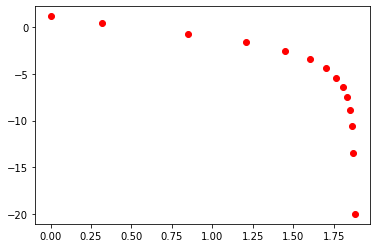

In [6]:
start = time.time()
r,v, v_dot, data = film.solve_with_values(mat.kT_to_J(-20),mat.kT_to_J(-1000.038))

v_E = film.material.kT_to_J(v)


charges = [1-film.material.n(vv)[0] for vv in v_E]



dF = pd.DataFrame({'r':r,'v':v,'v_dot':v_dot, 'charges':charges}, index = r)
dF = dF.sort_index()


charge = np.trapz(dF['charges']/film.material.nb,dF['r'])


print(charge)
fig, axe = subplots()
axe.plot(r,v,'ro')
len(r)


# calc the inital values with gauss law

In [7]:
%matplotlib inline

-1132.4314116179662 0.0 10
0.0 0.0 0.0 0.0 0.0


r    v  v_dot       charges
0.000000    0.000000  0.0    0.0  3.709267e+24
56.126021  56.126021  0.0    0.0  3.709267e+24
66.126021  66.126021  0.0    0.0  3.709267e+24
67.126021  67.126021  0.0    0.0  3.709267e+24
67.226021  67.226021  0.0    0.0  3.709267e+24

change


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73

-1132.4314116179662 -999.9999999999999 10
67.23459648416967 -1067.236019824333 -999.9999999999999 -1000.0 -1000.0014233401633


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp


r             v        v_dot       charges
0.000000    0.000000  69497.473510 -1067.236020  0.000000e+00
56.134663  56.134663  11164.089415 -1011.101357  0.000000e+00
66.126878  66.126878   1110.869709 -1001.109142  0.000000e+00
67.126099  67.126099    111.039178 -1000.109921  2.545152e-24
67.226021  67.226021     11.111039 -1000.009999  6.354808e+19

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning

(-1200.0,
   message: 'The solver successfully reached the end of the integration interval.'
      nfev: 56
      njev: 0
       nlu: 0
       sol: None
    status: 0
   success: True
         t: array([67.23713233, 67.2371315 , 67.23712316, 67.23703983, 67.2362065 ,
        67.22787317, 67.14453991, 66.31120727, 57.97788092,  0.        ])
  t_events: [array([67.23713233])]
         y: array([[ 0.00000000e+00,  9.99999162e-04,  1.09999908e-02,
          1.10999907e-01,  1.11099918e+00,  1.11110257e+01,
          1.11115108e+02,  1.11153788e+03,  1.11539600e+04,
          8.29449124e+04],
        [-1.20000000e+03, -1.20000000e+03, -1.20000000e+03,
         -1.20000000e+03, -1.20000034e+03, -1.20000833e+03,
         -1.20009167e+03, -1.20092500e+03, -1.20925832e+03,
         -1.26723621e+03]]))

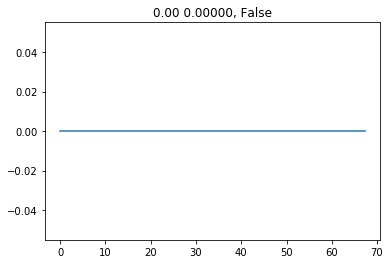

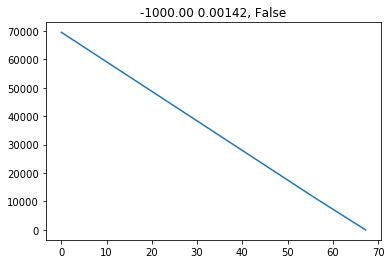

In [20]:
def get_E_dot_init_kT(film , E_init_kT, do_plot=False,E_dot_init_kT=None, change_factor=None):
    mat = film.material
    if E_dot_init_kT:
       pass
    else:
        E_dot_init_kT = E_init_kT/np.e
    E_init = mat.kT_to_J(E_init_kT)
    #film.set_lookup_mode()
    if change_factor:
        pass
    else:
        change_factor = 10
    boost_factor = 1
    is_over = True
    prev_min_index_mode = False
    tune_for_min_index = False
    min_index = None
    direction = 1
    regular_mode = True
    
    for i in range(5000):


        E_dot_init = mat.kT_to_J(E_dot_init_kT)

        old_min_index = min_index
        r,v,v_dot,data = film.solve_with_values(E_init, E_dot_init)
        
        
        #min_index = np.argmin(abs(v_dot))
        min_index = v_dot[-1]
        
        
        #v[min_index:]=v[min_index]
        #v_dot[min_index:]=v_dot[min_index]

        v_E = film.material.kT_to_J(v)
        
        charges = [film.material.n(vv)[0] for vv in v_E]
        dF = pd.DataFrame({'r':r,'v':v,'v_dot':v_dot, 'charges':charges}, index = r)
        dF = dF.sort_index()
        
        integral = np.trapz(1-dF['charges']/film.material.nb,dF['r'])
        v_b_dot_kT = dF.iloc[0]['v_dot']
        v_s_dot_kT_int = integral+v_b_dot_kT
        
        
        #display(dF)
        
        
        if do_plot and (i%100==0):
            print(charge,dF.iloc[-1]['v_dot'], change_factor)
            print(integral, v_b_dot_kT, dF.iloc[-1]['v_dot'], E_dot_init_kT, v_s_dot_kT_int)
            fig, axe = subplots(1)
            axe.clear()
            axe.plot(dF['v'])
            axe.set_title(f'{E_dot_init_kT:.2f} {E_dot_init_kT-v_s_dot_kT_int:.5f}, {tune_for_min_index}')
            #axe.set_ylim(-20,20)
            display(dF.head())
        
        if abs((E_dot_init_kT-v_s_dot_kT_int)/E_dot_init_kT)*100<0.0001:
            break
            tune_for_min_index = True
        else:
            #tune_for_min_index = False
            pass
        
        if tune_for_min_index:
            if prev_min_index_mode:
                pass
            else:
                #change_factor *= 0.8
                prev_min_index_mode = True
            if old_min_index:
                if abs(min_index)<=abs(old_min_index):
                    pass
                else:
                    direction *= -1
                    change_factor *= 0.8
                E_dot_init_kT = E_dot_init_kT+direction*change_factor*boost_factor
                
            else:
                pass
            
            if abs(min_index)<0.1:
                fig, axe = subplots(1)
                axe.clear()
                axe.plot(dF['v'],'o')
                axe.set_title(f'{E_dot_init_kT:.2f}, {((E_dot_init_kT-charge)/(abs(E_dot_init_kT)+0.0001))*100:.5f}, {charge}, {tune_for_min_index}')
                axe.set_ylim(-20,20)
                break
            
        
            
        else:
            reduce_factor = 0.6
            if prev_min_index_mode:
                change_factor *= reduce_factor
                prev_min_index_mode = False
            else:
                pass
            old_ids_over = is_over
            
            

            
            if E_init_kT<=0:
                if (v_b_dot_kT>=E_dot_init_kT) and (v_b_dot_kT<=0):
                    pass
                else:
                    E_dot_init_kT = E_dot_init_kT-change_factor
                    regular_mode = False
                    continue
            else:
                if (v_b_dot_kT<=E_dot_init_kT) and (v_b_dot_kT>=0):
                    pass
                else:
                    E_dot_init_kT = E_dot_init_kT+change_factor
                    regular_mode = False
                    continue
                    
            
                    
            old_ids_over = is_over        
            if E_dot_init_kT>=v_s_dot_kT_int:
                is_over = True
                E_dot_init_kT = E_dot_init_kT-change_factor
            else:
                E_dot_init_kT = E_dot_init_kT+change_factor
                is_over = False        
                
            print('change')
            if regular_mode:
                pass
            else:
                regular_mode = True
                change_factor *= reduce_factor
            
            
            if old_ids_over==is_over:
                switch = False
            else:
                change_factor = change_factor*reduce_factor
                switch = True
                print('switch')
            

            
            



        #if abs(charge-dF.iloc[-1]['v_dot'])<0.001:
        #    break

    return E_dot_init_kT,data
E_init_kT = 0
#get_E_dot_init_kT(film, E_init_kT, do_plot=True,E_dot_init_kT=-1000.0995358861533,change_factor=0.1)
get_E_dot_init_kT(film, E_init_kT, do_plot=True)

In [27]:
E_EF_EC_diff = 0.22
thickness = 200e-9

mat = Material(300,DIFF_EF_EC_evolt=E_EF_EC_diff,mass_e_eff_factor=0.275,EPSILON=12)
film = FILM(thickness, mat)


[1.88132051 1.88121902 1.8802041  1.87438048 1.8659137  1.85575999
 1.84560629 1.83341471 1.7114989  0.49234074 0.        ]
Min index is: 11 of 11
-4607281.7324827425 -7.357588823428847 10
-4607281.7324827425
r          1.881321e+00
v         -2.000000e+01
v_dot     -7.357589e+00
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 6.0


[1.88132051 1.88113626 1.87929374 1.87273753 1.86386523 1.85623397
 1.84781763 1.83835416 1.74371949 0.79737278 0.        ]
Min index is: 11 of 11
-4605473.986405633 -13.357588823428847 6.0
-4605473.986405633
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.335759e+01
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


[1.88132051 1.8786539  1.87213937 1.86358161 1.85335602 1.84313042
 1.82945544 1.69270556 0.32520684 0.        ]
Min index is: 10 of 10
-4603381.747449994 -193.35758882342884 6.0
-4603381.747449994
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.933576e+02
charges    2.977381e+2

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retai

[1.88132051 1.87101855 1.86071659 1.84732741 1.8252057  1.79132372
 1.78457756]
Min index is: 7 of 7
-1017.2450064225548 -1007.5140048234289 0.2799359999999999
-1017.2450064225548
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.007514e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


[1.88132051 1.8710182  1.8607159  1.84729525 1.8250889  1.79113538
 1.78586441]
Min index is: 7 of 7
-1015.2494190599422 -1007.7939408234289 0.2799359999999999
-1015.2494190599422
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.007794e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


[1.88132051 1.87101786 1.86071521 1.84726283 1.8249859  1.79097123
 1.78709037]
Min index is: 7 of 7
-1013.2848911907837 -1008.0738768234289 0.2799359999999999
-1013.2848911907837
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008074e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


[1.88132051 1.87101752 1.86071452 1.84723015 1

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retai

-1009.4457563069678
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008634e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


[1.88132051 1.87101684 1.86071316 1.84716401 1.82474496 1.79058985
 1.7904491 ]
Min index is: 7 of 7
-1007.5702933382283 -1008.913684823429 0.2799359999999999
-1007.5702933382283
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008914e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.16796159999999993


[1.88132051 1.87101704 1.86071357 1.84718396 1.82478635 1.79065572
 1.78981235]
Min index is: 7 of 7
-1008.6920671871446 -1008.7457232234291 0.16796159999999993
-1008.6920671871446
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008746e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


[1.88132051 1.87101724 1.86071397 1.84720382 1.82483076 1.79072602
 1.7891589 ]
Min index is: 7 of 7
-1009.8243573591981 -1008.577761623429 0.16796159999999993
-1009.8243573591

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retai

 -1008.7464219436849 0.013060694015999994
-1008.6873788516918
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008746e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.007836416409599997


[1.88132051 1.87101705 1.86071358 1.84718481 1.82478817 1.79065861
 1.78978492]
Min index is: 7 of 7
-1008.7399707618254 -1008.7385855272752 0.007836416409599997
-1008.7399707618254
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008739e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.004701849845759998


[1.88132051 1.87101704 1.86071357 1.84718425 1.82478697 1.7906567
 1.78980299]
Min index is: 7 of 7
-1008.7084128688241 -1008.743287377121 0.004701849845759998
-1008.7084128688241
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008743e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0028211099074559984


[1.88132051 1.87101705 1.86071358 1.84718459 1.82478769 1.79065785
 

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retai

[1.88132051 1.87101705 1.86071359 1.84718484 1.82478824 1.79065872
 1.78978391]
Min index is: 7 of 7
-1008.7417382475115 -1008.7383222236838 0.0010155995666841593
-1008.7417382475115
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008738e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0006093597400104956


[1.88132051 1.87101705 1.86071358 1.84718477 1.82478808 1.79065847
 1.78978625]
Min index is: 7 of 7
-1008.7376478199463 -1008.7389315834238 0.0006093597400104956
-1008.7376478199463
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008739e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0003656158440062973


[1.88132051 1.87101705 1.86071358 1.84718481 1.82478817 1.79065862
 1.78978485]
Min index is: 7 of 7
-1008.7401020598745 -1008.7385659675798 0.0003656158440062973
-1008.7401020598745
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.008739e+03
charges    2.977381e+26
Name: 1.8813205

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


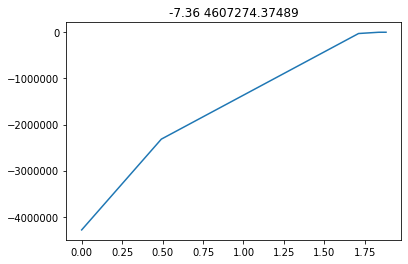

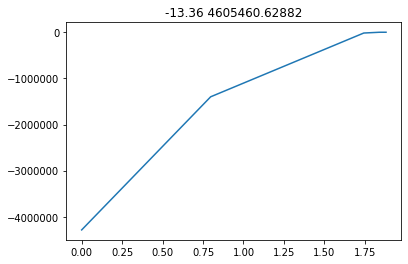

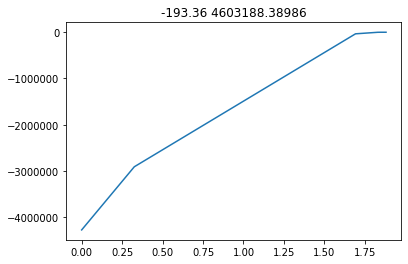

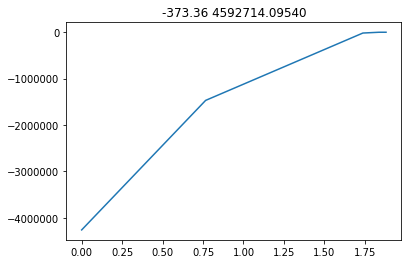

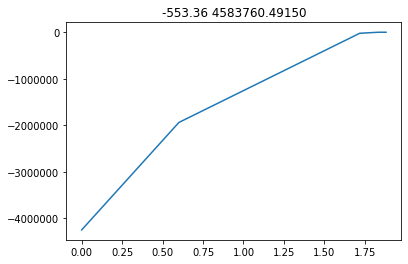

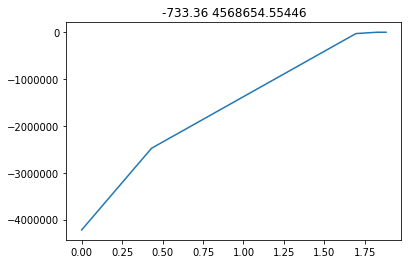

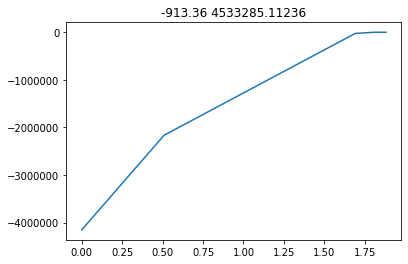

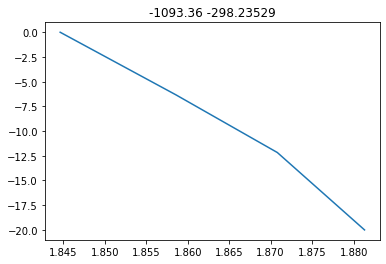

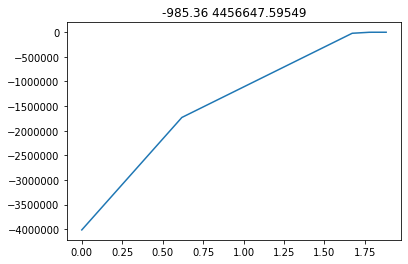

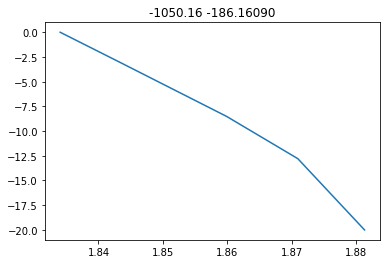

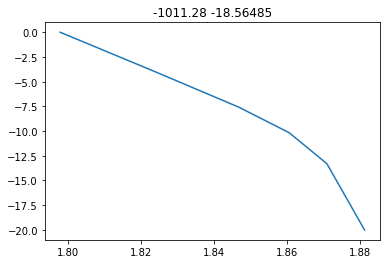

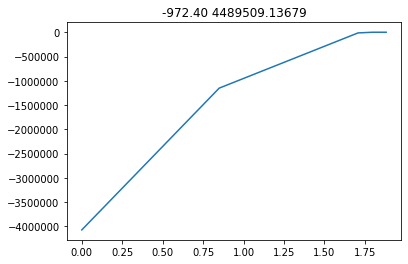

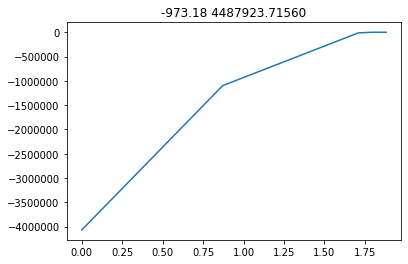

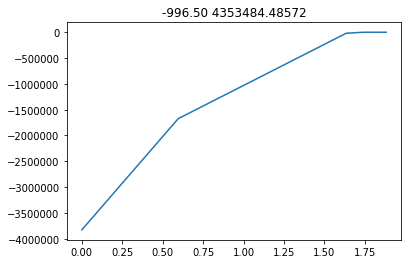

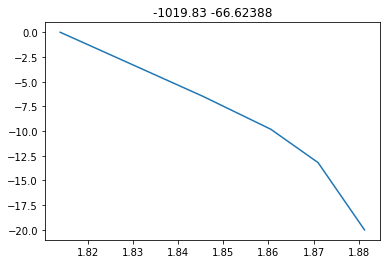

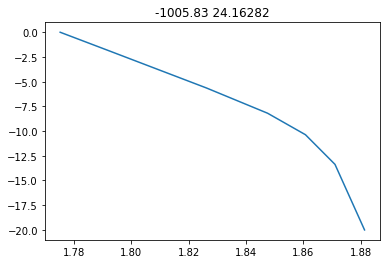

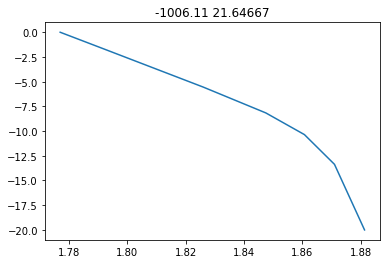

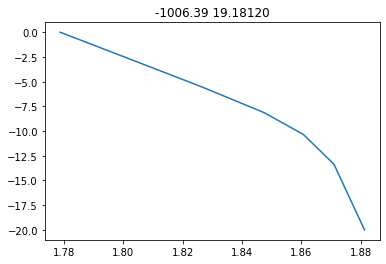

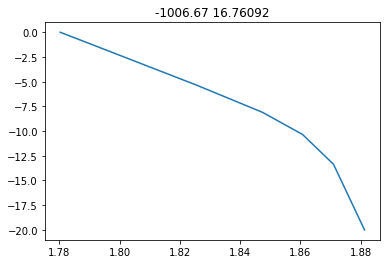

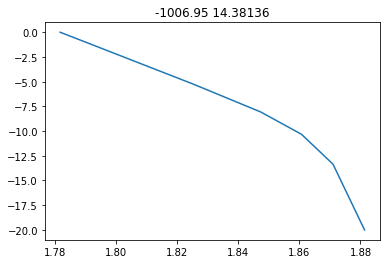

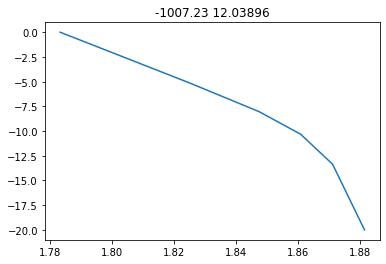

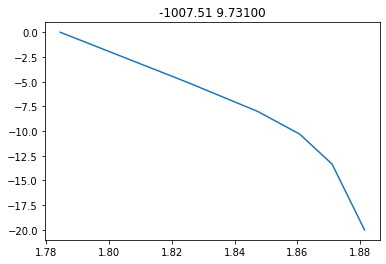

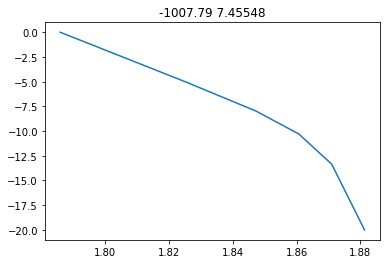

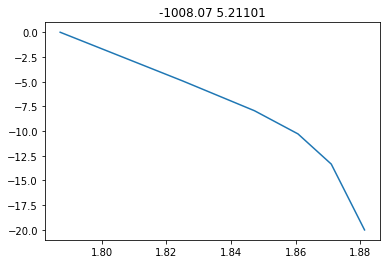

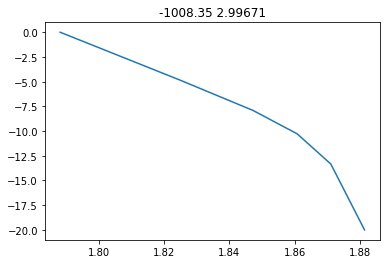

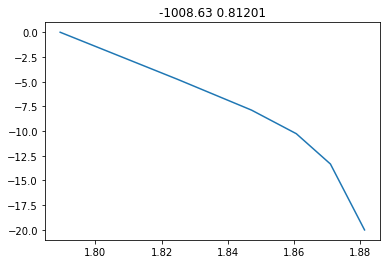

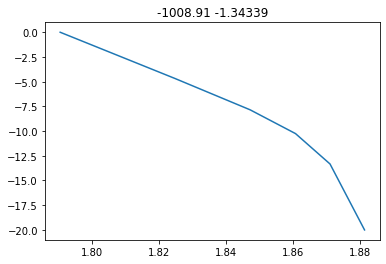

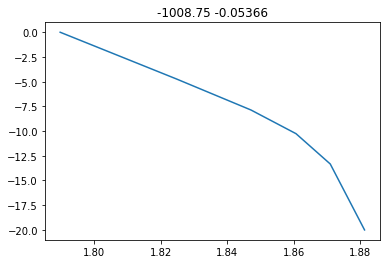

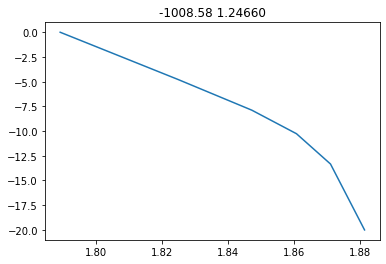

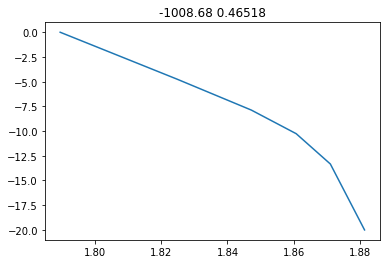

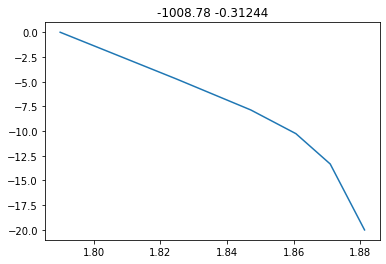

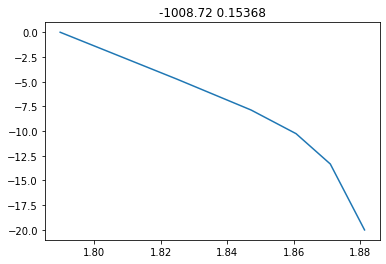

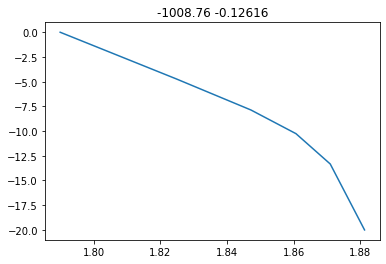

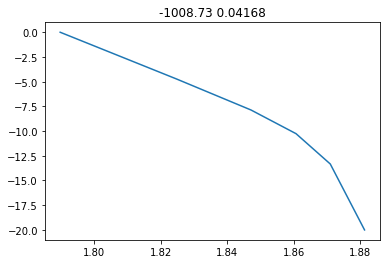

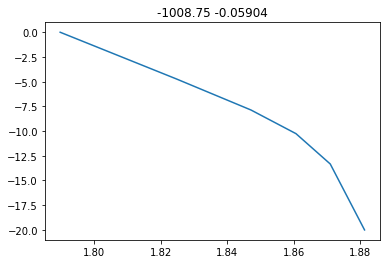

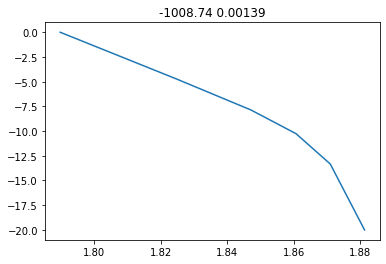

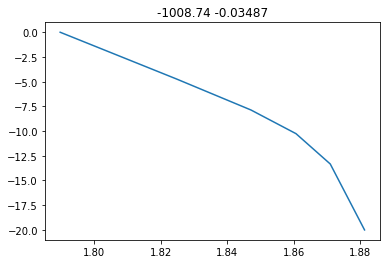

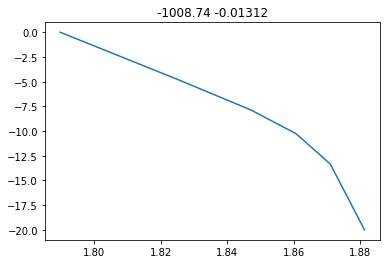

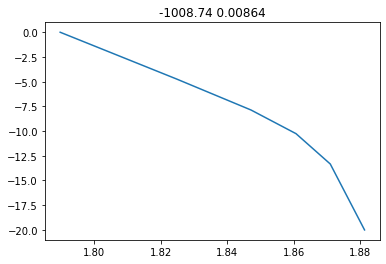

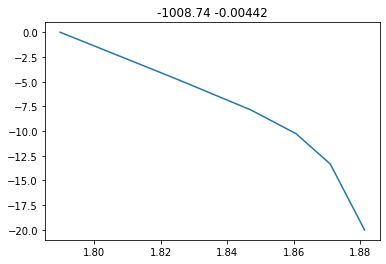

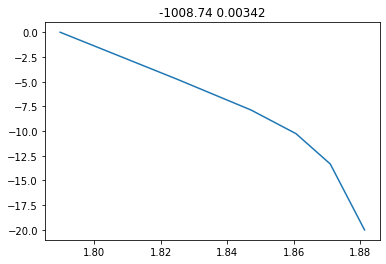

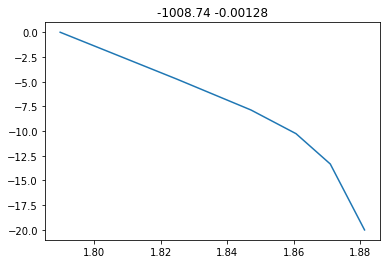

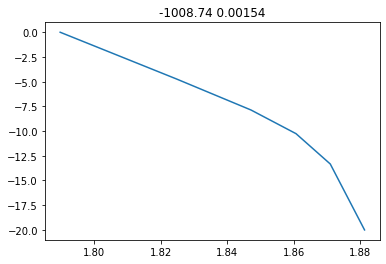

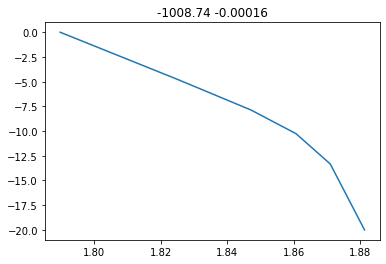

In [113]:
E_dot_init_kT, data = get_E_dot_init_kT(film, -20, do_plot=True)

Calc. for 200.0nm with EC_EF = 0.4
1.8777584503005464
r          1.881321e+00
v          1.000000e+01
v_dot      3.678794e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8796023505069739
r          1.881321e+00
v          1.000000e+01
v_dot      3.178794e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.880336235086109
r          1.881321e+00
v          1.000000e+01
v_dot      2.778794e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.880677619039891
r          1.881321e+00
v          1.000000e+01
v_dot      2.458794e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8808566862435934
r          1.881321e+00
v          1.000000e+01
v_dot      2.202794e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8809597216684677
r          1.881321e+00
v          1.000000e+01
v_dot      1.997994e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810233970169519
r          1.88132

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8809977764198191
r          1.881321e+00
v          1.000000e+01
v_dot      1.904592e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8809998668563734
r          1.881321e+00
v          1.000000e+01
v_dot      1.899094e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810015278477015
r          1.881321e+00
v          1.000000e+01
v_dot      1.894696e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810028494197082
r          1.881321e+00
v          1.000000e+01
v_dot      1.891178e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810039020802658
r          1.881321e+00
v          1.000000e+01
v_dot      1.888363e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810047412790452
r          1.881321e+00
v          1.000000e+01
v_dot      1.886111e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810054107694274
r          1.881321e+00
v          1.000000e+01
v_dot      1.884310e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810059451690422
r          1.881321e+00
v          1.000000e+01
v_dot      1.882869e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1.8810063719270649
r          1.881321e+00
v          1.000000e+01
v_dot      1.881716e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64
1.8810080722100158
r          1.881321e+00
v          1.000000e+01
v_dot      1.877104e+00
charges    1.318552e+17
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

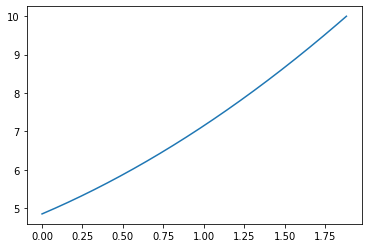

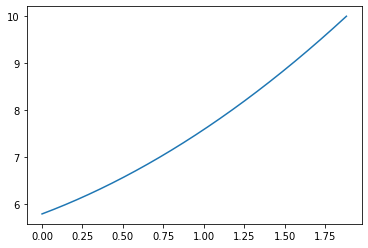

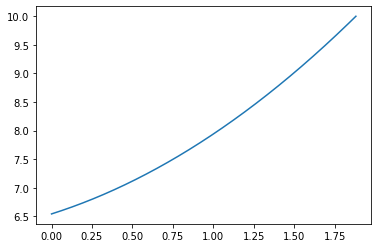

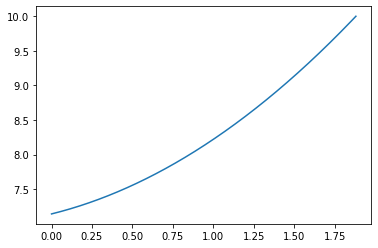

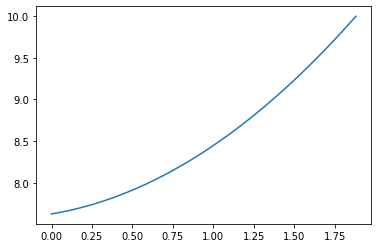

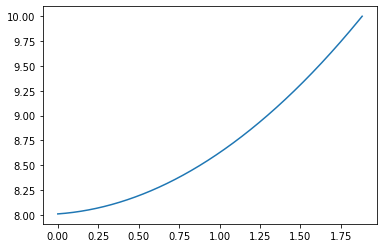

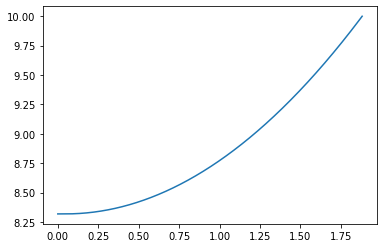

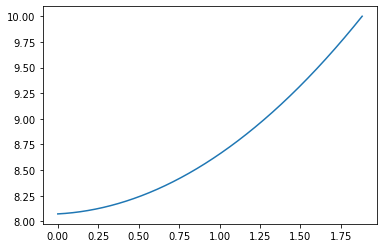

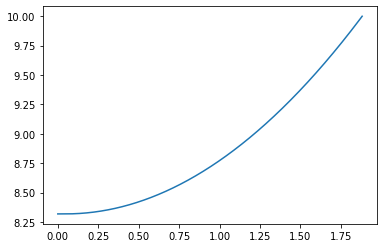

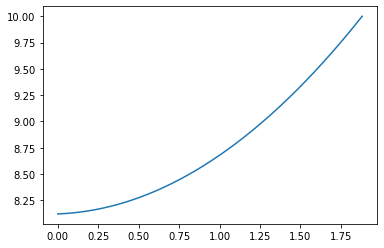

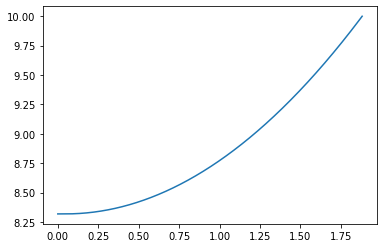

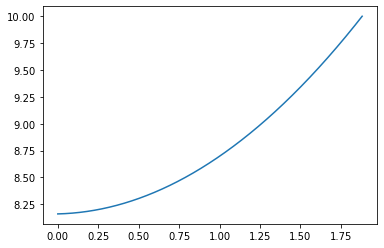

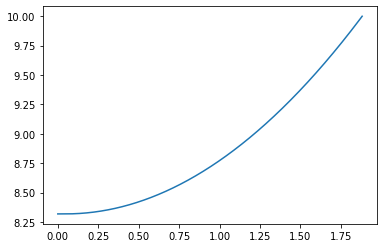

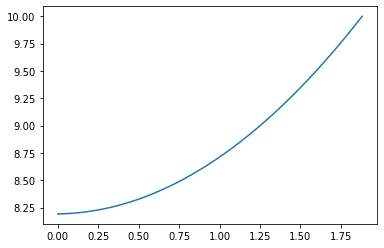

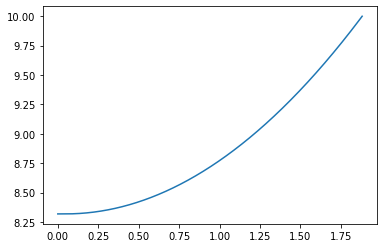

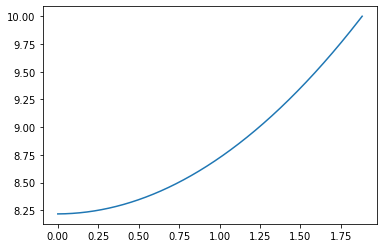

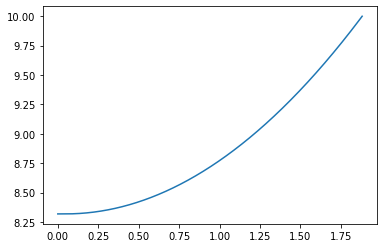

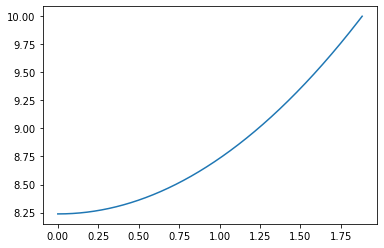

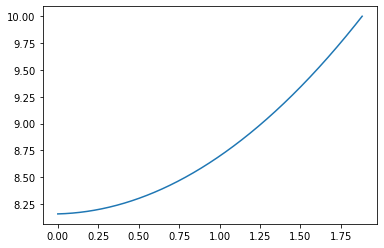

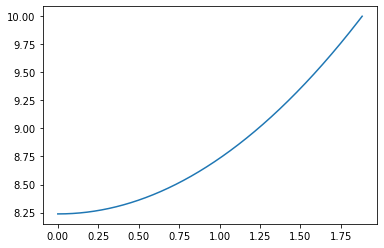

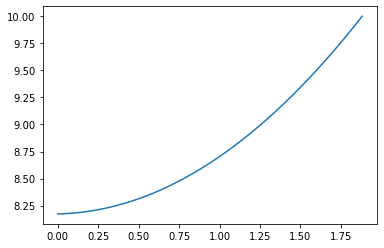

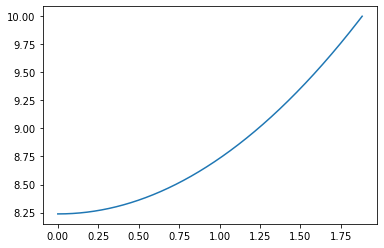

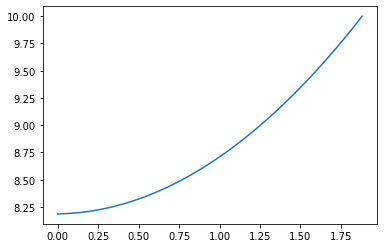

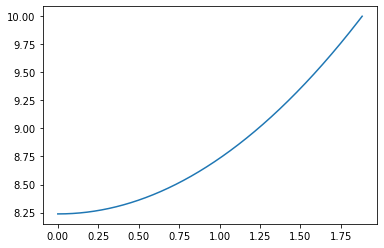

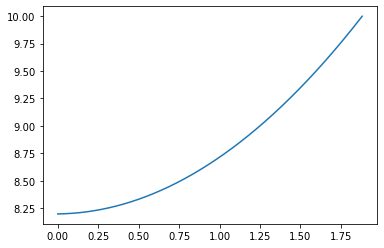

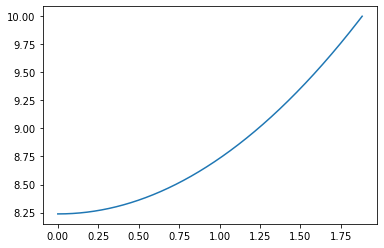

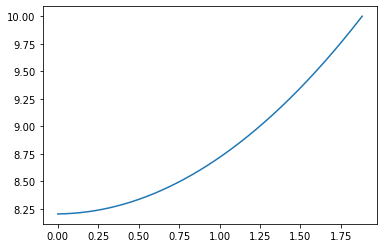

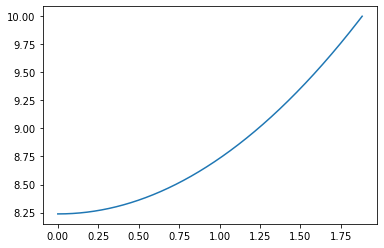

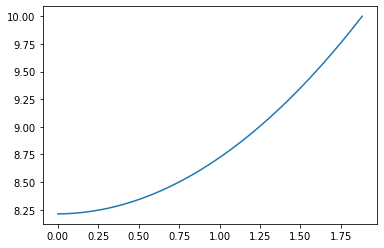

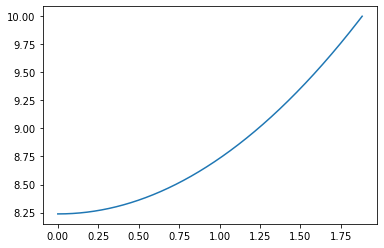

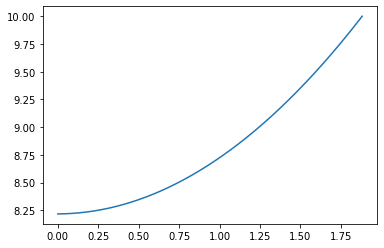

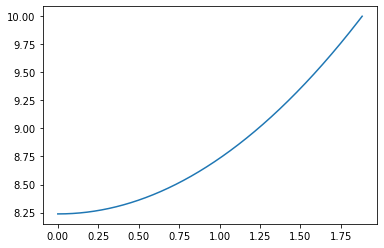

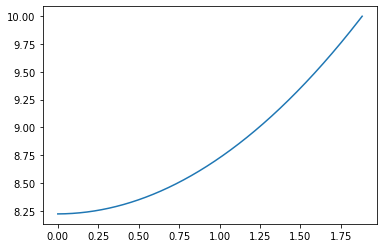

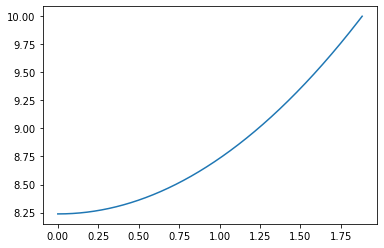

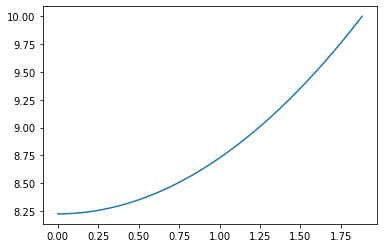

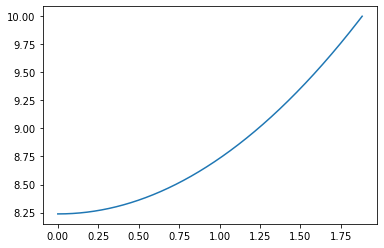

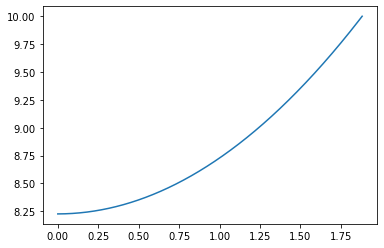

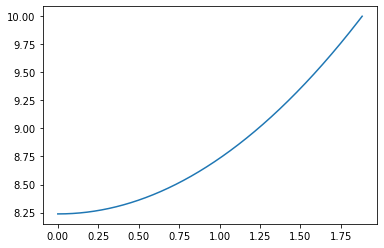

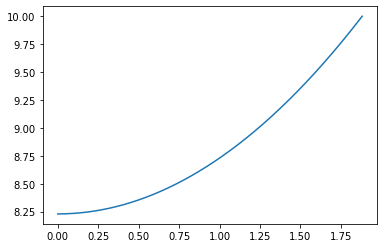

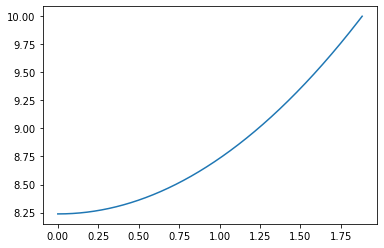

In [258]:
E_EF_EC_diff = 0.400
mat = Material(300,DIFF_EF_EC_evolt=E_EF_EC_diff,mass_e_eff_factor=0.275,EPSILON=12)
thickness = 200e-9
print(f'Calc. for {thickness*1e9}nm with EC_EF = {E_EF_EC_diff}')
film = FILM(thickness, mat)

E_init_kT = 10
get_E_dot_init_kT(film, E_init_kT, do_plot=True)

# calc the inital values with Voodoo
"don't do voodoo at work!"

-67.23705885462441 130479.57554100631 131110.10786432883
-67.23705885462441 129976.29632665782 130479.57554100631
-67.23705885462441 129504.50786150662 129976.29632665782
-67.23705885462441 128872.24064010929 129504.50786150662
-67.23705885462441 128053.25021275636 128872.24064010929
-67.23705885462441 126733.37709161596 128053.25021275636
-67.23705885462441 124402.31259100327 126733.37709161596
-67.23705885462441 -63.01523593054921 124402.31259100327
-63.01523593054921 122501.04919381025 124402.31259100327
-63.01523593054921 120261.74175558248 122501.04919381025
-63.01523593054921 117036.73554104652 120261.74175558248
-63.01523593054921 -61.77718275406779 117036.73554104652
-61.77718275406779 114132.09754249376 117036.73554104652
-61.77718275406779 -60.17354537745017 114132.09754249376
-60.17354537745017 111818.41946677251 114132.09754249376
-60.17354537745017 101402.96762471434 111818.41946677251
-60.17354537745017 -59.44593051453395 101402.96762471434
-59.44593051453395 -58.70223957

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-50.317811632434704 90237.14773639066 93591.7968456388
-50.317811632434704 -49.16049772284884 90237.14773639066
-49.16049772284884 -44.907094809015106 90237.14773639066
-44.907094809015106 88773.32342884608 90237.14773639066
-44.907094809015106 87235.55358104559 88773.32342884608
-44.907094809015106 85648.55457869158 87235.55358104559
-44.907094809015106 83817.61358399928 85648.55457869158
-44.907094809015106 81228.04633182538 83817.61358399928
-44.907094809015106 -43.01832988452726 81228.04633182538
-43.01832988452726 79176.48768997737 81228.04633182538
-43.01832988452726 75280.11891064818 79176.48768997737
-43.01832988452726 -42.014753089587074 75280.11891064818
-42.014753089587074 -40.396296364511684 75280.11891064818
-40.396296364511684 72807.4935404392 75280.11891064818
-40.396296364511684 -38.03352864186433 72807.4935404392
-38.03352864186433 71091.92893084136 72807.4935404392
-38.03352864186433 68802.85191542124 71091.92893084136
-38.03352864186433 59660.77426522851 68802.851915

(4.226581667935923,
   message: 'The solver successfully reached the end of the integration interval.'
      nfev: 224
      njev: 0
       nlu: 0
       sol: None
    status: 0
   success: True
         t: array([67.23713233, 67.11323003, 65.874207  , 64.21006044, 63.4053591 ,
        62.32495267, 61.32526659, 60.30783789, 59.29040919, 58.27298049,
        57.25555179, 56.23812309, 55.22069439, 54.16838533, 52.9975995 ,
        51.6436484 , 50.01135225, 47.96210473, 45.26960243, 41.5922439 ,
        36.9745599 , 34.29616663, 32.45175435, 30.60734206, 28.76292978,
        26.91851749, 25.07410521, 22.52255881, 18.03495689,  0.        ])
  t_events: [array([], dtype=float64)]
         y: array([[ 1.00000000e+01,  9.48399221e+00,  5.16768136e+00,
          1.73173958e+00,  9.09617357e-01,  3.55182971e-01,
          1.42937210e-01,  5.56723986e-02,  2.15397517e-02,
          8.31220104e-03,  3.20447139e-03,  1.23489198e-03,
          4.75813587e-04,  1.77464811e-04,  5.93037585e-05,
     

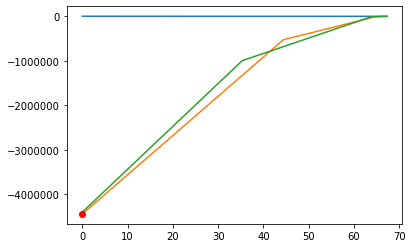

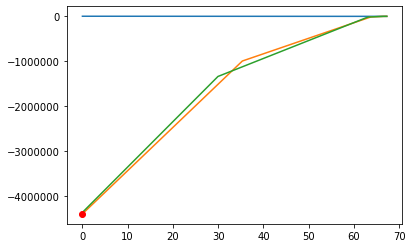

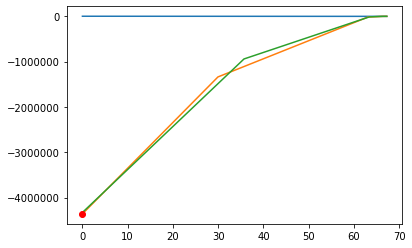

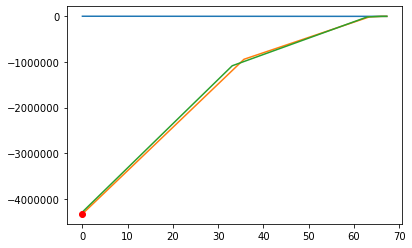

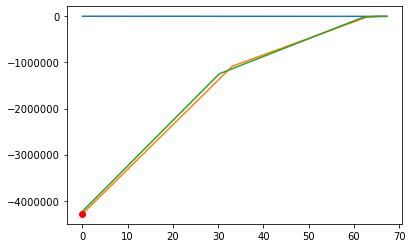

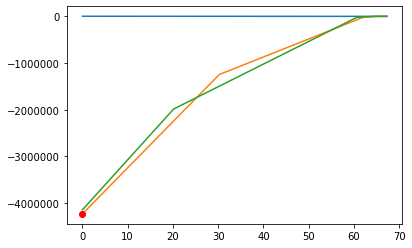

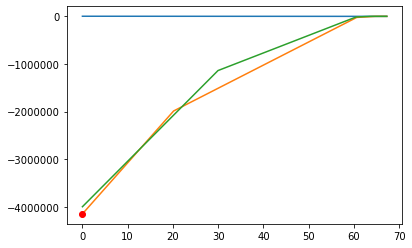

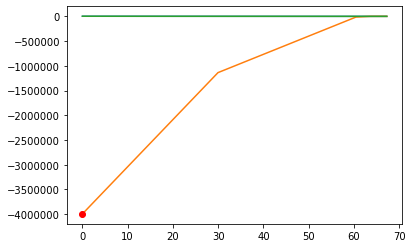

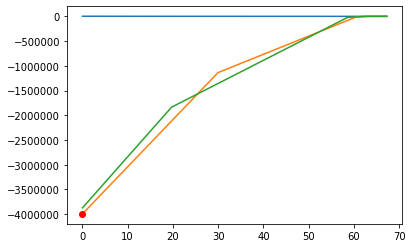

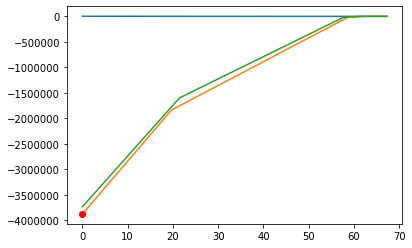

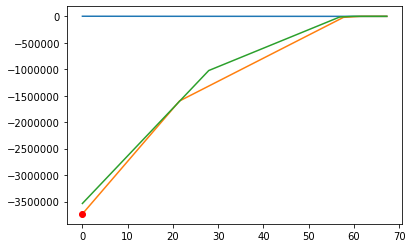

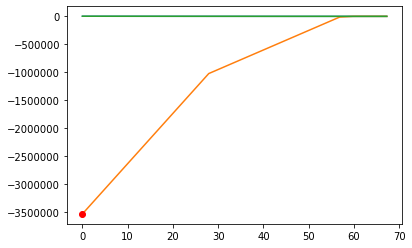

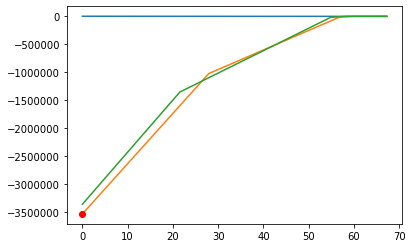

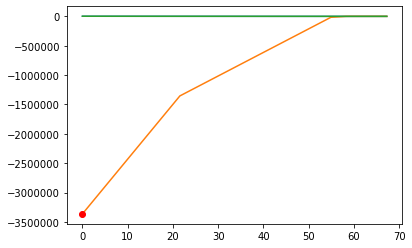

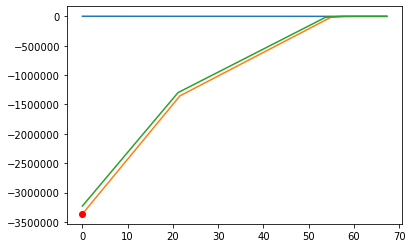

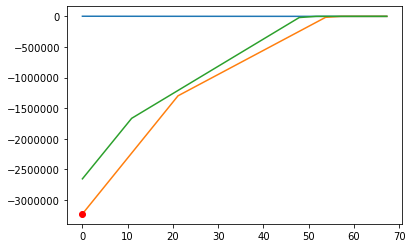

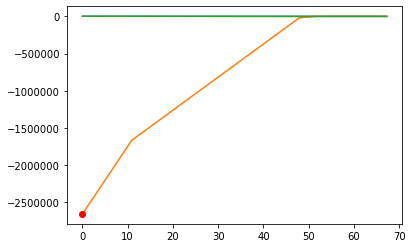

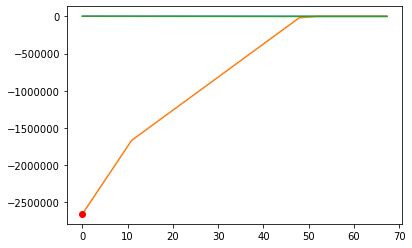

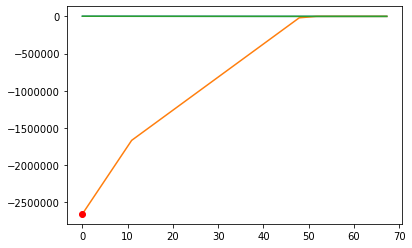

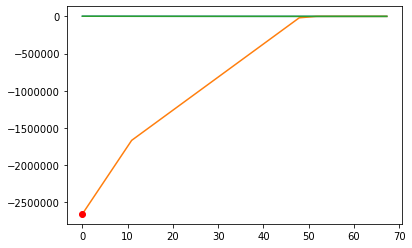

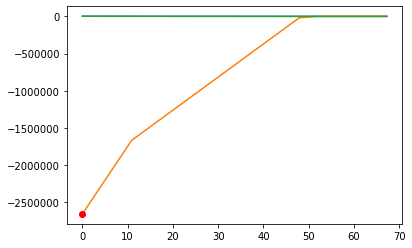

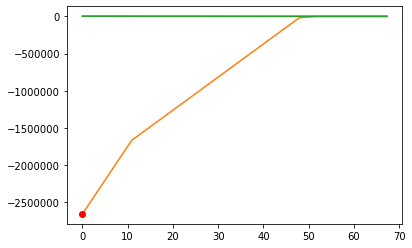

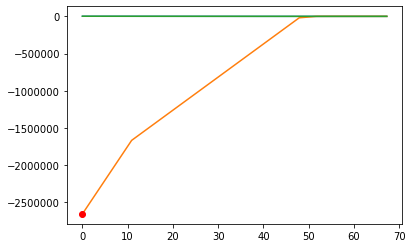

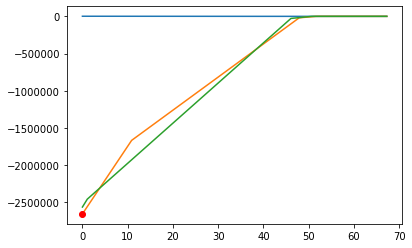

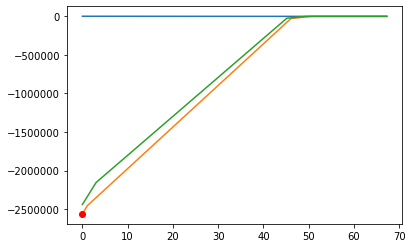

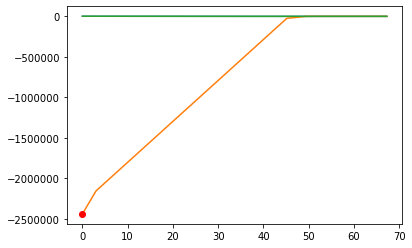

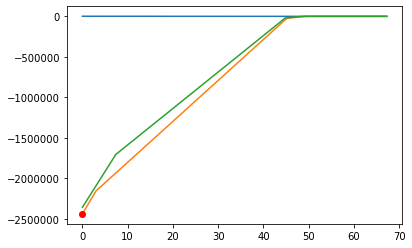

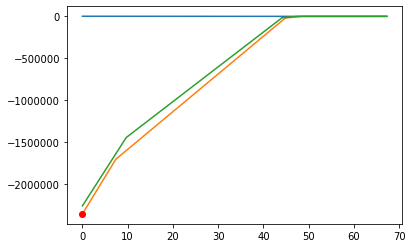

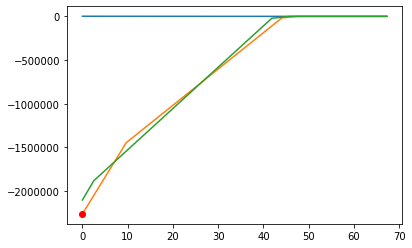

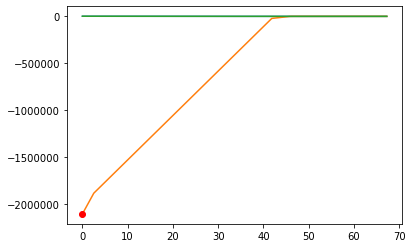

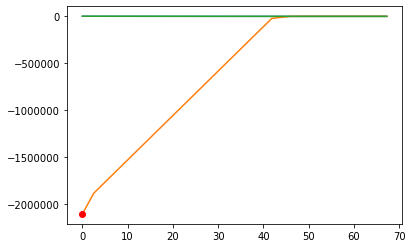

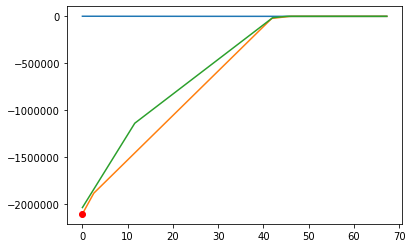

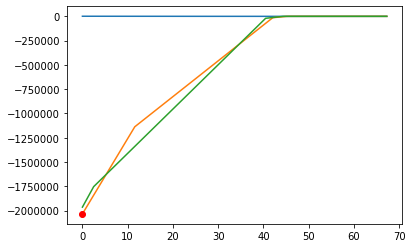

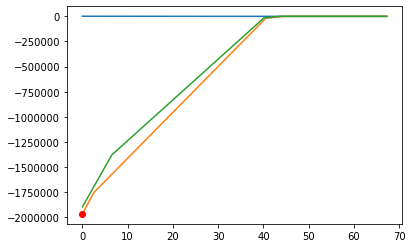

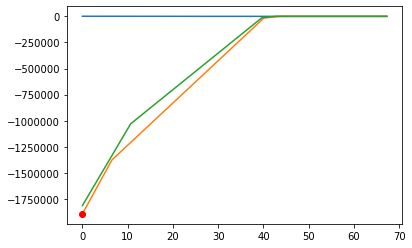

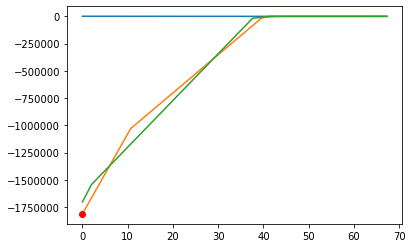

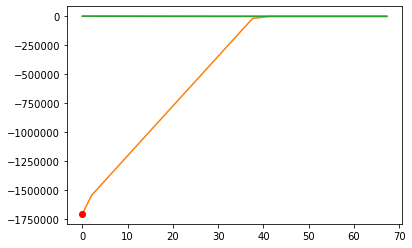

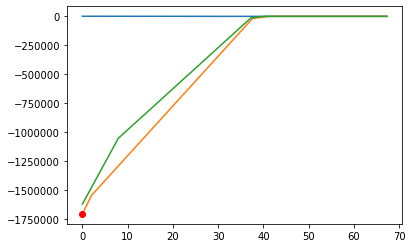

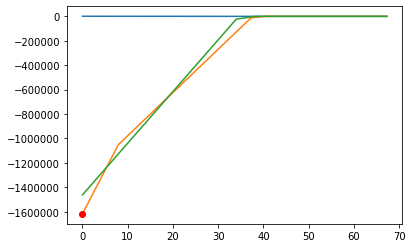

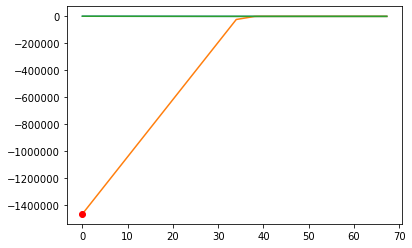

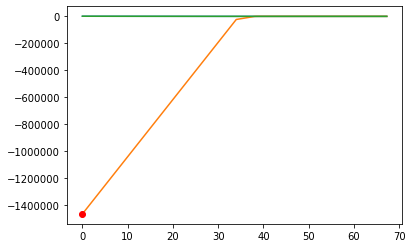

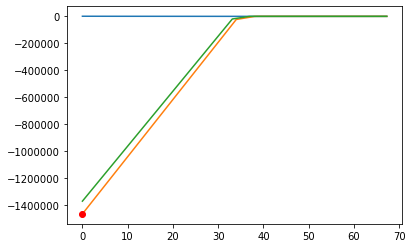

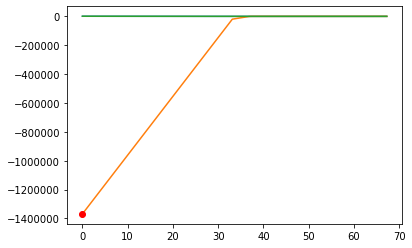

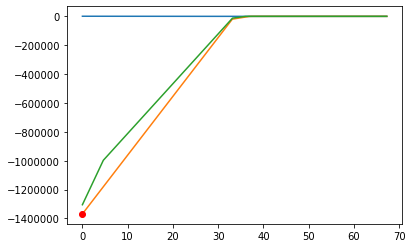

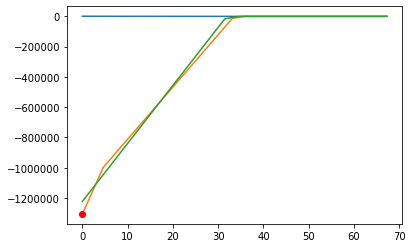

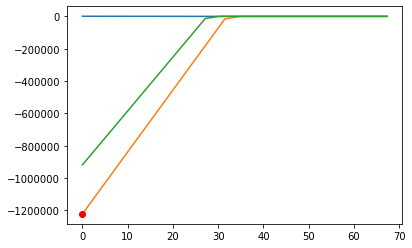

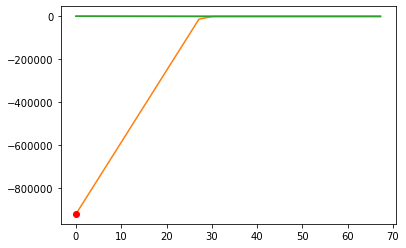

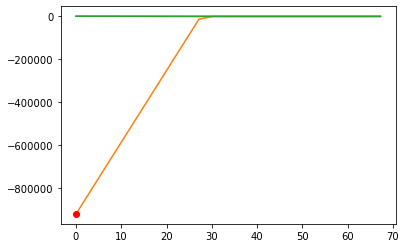

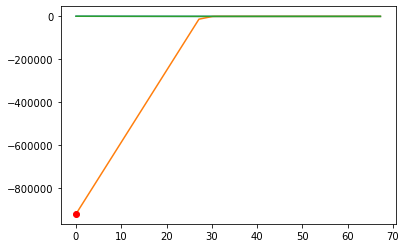

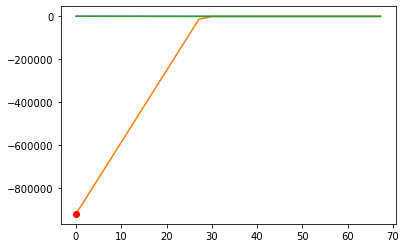

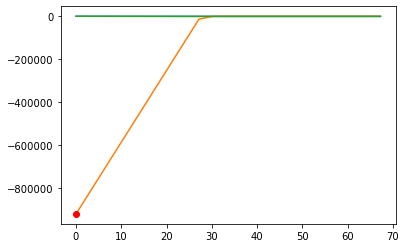

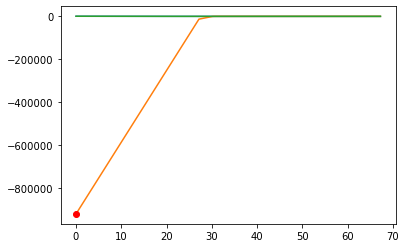

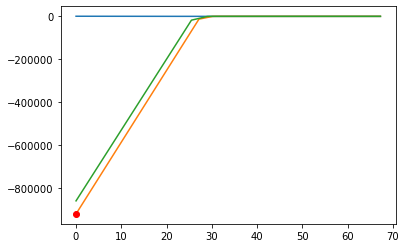

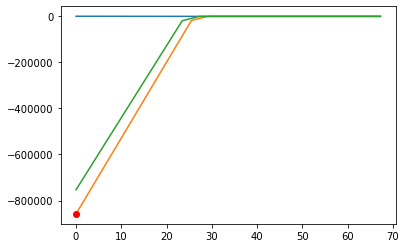

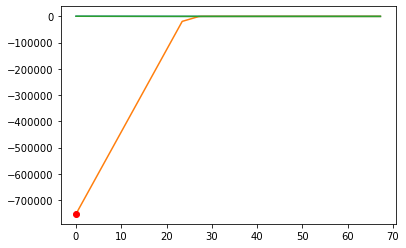

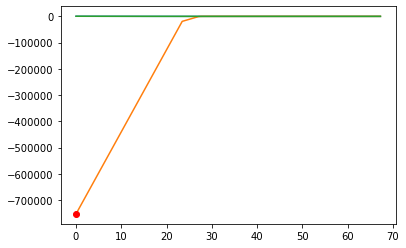

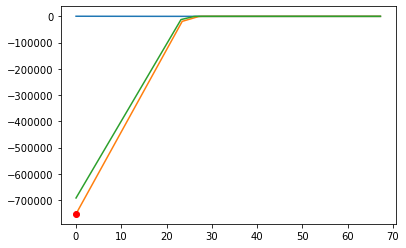

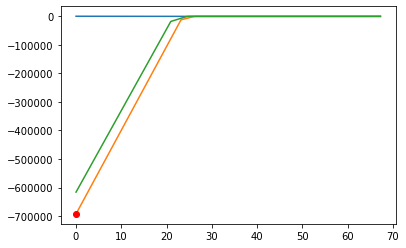

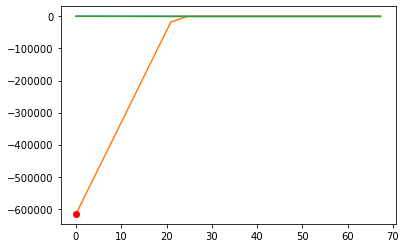

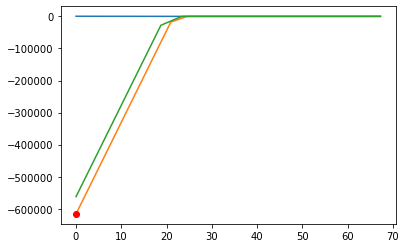

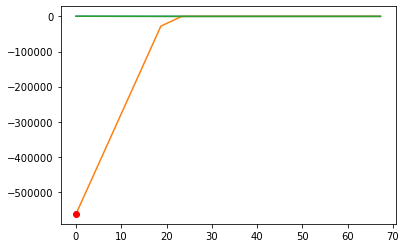

In [25]:

def get_E_dot_init_kT(film, E_init_kT, do_plot=False):
    mat = film.material
    E_dot_init_kT_min = 0
    E_dot_init_kT_max = E_init_kT*100
    E_dot_init_kT_mid = None
    E_init = mat.kT_to_J(E_init_kT)
    #film.set_lookup_mode()
    for i in range(100):

        E_dot_init_kT_mid_new = (E_dot_init_kT_min+E_dot_init_kT_max)/2
        if E_dot_init_kT_mid_new==E_dot_init_kT_mid:
            if not(film.do_lookup):
                break
            else:
                #print('Enter Calc Mode.')
                #film.set_calc_mode()
                break
        else:
            E_dot_init_kT_mid=E_dot_init_kT_mid_new

        E_dot_init_mid = mat.kT_to_J(E_dot_init_kT_mid)
        E_dot_init_min = mat.kT_to_J(E_dot_init_kT_min)
        E_dot_init_max = mat.kT_to_J(E_dot_init_kT_max)


        r_min,v_min,v_dot_min,data_min = film.solve_with_values(E_init, E_dot_init_min)
        r_max,v_max,v_dot_max,data_max = film.solve_with_values(E_init, E_dot_init_max)
        r_mid,v_mid,v_dot_mid,data_mid = film.solve_with_values(E_init, E_dot_init_mid)
        if do_plot:
            fig, axe = subplots(1)
            axe.plot(r_min, v_min, label = 'min')
            axe.plot(r_max, v_max, label = 'max')
            axe.plot(r_mid, v_mid, label = 'mid')
            axe.plot(r_max[-1], v_max[-1],'ro', label = 'max')
            print(v_dot_min[-1],v_dot_mid[-1],v_dot_max[-1])
        do_redo = False


        if sign(E_init_kT)*v_max[-1]<0:
            pass
        else:
            E_dot_init_kT_max*=2
            do_redo = True

        if sign(E_init_kT)*v_min[-1]>0:
            pass

        else:
            E_dot_init_kT_min*=0.5
            do_redo = True

        if do_redo:
            continue
        else:
            pass
        if sign(E_init_kT)*v_mid[-1]>0:
            E_dot_init_kT_min = E_dot_init_kT_mid
        else:
            E_dot_init_kT_max = E_dot_init_kT_mid
    return E_dot_init_kT_mid,data_mid
E_init_kT = 10
get_E_dot_init_kT(film, 10, do_plot=True)

In [8]:
%matplotlib inline

-16590.26810253414 -3.6787944117144233
-16590.26810253414
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.678794e+00
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64
Shrink to 0.8
-16587.009869578218 -4.478794411714423
-16587.009869578218
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.478794e+00
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64
-16583.112308602234 -5.278794411714423
-16583.112308602234
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.278794e+00
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64
-16578.575239129917 -6.078794411714423
-16578.575239129917
r          1.881321e+00
v         -1.000000e+01
v_dot     -6.078794e+00
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64
-16573.398456488016 -6.878794411714422
-16573.398456488016
r          1.881321e+00
v         -1.000000e+01
v_dot     -6.878794e+00
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64
-16567.58178

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16387.16589664613 -20.478794411714432
-16387.16589664613
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.047879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16370.402561035608 -21.278794411714433
-16370.402561035608
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.127879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16352.989446877897 -22.078794411714433


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16352.989446877897
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.207879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64
-16334.925644263454 -22.878794411714434
-16334.925644263454
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.287879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16316.210168555048 -23.678794411714435
-16316.210168555048
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.367879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16296.842190786818 -24.478794411714436
-16296.842190786818
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.447879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16276.820561951823 -25.278794411714436
-16276.820561951823
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.527879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16256.144451674254 -26.078794411714437
-16256.144451674254
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.607879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16234.812592670001 -26.878794411714438
-16234.812592670001
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.687879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16212.82412833432 -27.678794411714435
-16212.82412833432
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.767879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16190.17769341858 -28.47879441171444
-16190.17769341858
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.847879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16166.872129144303 -29.27879441171444
-16166.872129144303
r          1.881321e+00
v         -1.000000e+01
v_dot     -2.927879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16142.906395680775 -30.078794411714437
-16142.906395680775
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.007879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16118.279192307295 -30.87879441171444
-16118.279192307295
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.087879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16092.989123438996 -31.678794411714442
-16092.989123438996
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.167879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16067.03496414018 -32.47879441171444
-16067.03496414018
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.247879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16040.415374723678 -33.278794411714436
-16040.415374723678
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.327879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-16013.128772785256 -34.07879441171443
-16013.128772785256
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.407879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15985.17388810959 -34.87879441171443
-15985.17388810959
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.487879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15956.549259171301 -35.67879441171443
-15956.549259171301
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.567879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15927.253099676464 -36.478794411714425
-15927.253099676464
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.647879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15897.2841054763 -37.27879441171442
-15897.2841054763
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.727879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15866.6405718615 -38.07879441171442
-15866.6405718615
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.807879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15835.321066942222 -38.878794411714416
-15835.321066942222
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.887879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15803.323285266208 -39.678794411714414
-15803.323285266208
r          1.881321e+00
v         -1.000000e+01
v_dot     -3.967879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15770.646038351928 -40.47879441171441
-15770.646038351928
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.047879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15737.287518009987 -41.27879441171441
-15737.287518009987
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.127879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15703.245480236736 -42.078794411714405
-15703.245480236736
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.207879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15668.518786514596 -42.8787944117144
-15668.518786514596
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.287879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15633.10471286148 -43.6787944117144
-15633.10471286148
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.367879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15597.001854991244 -44.4787944117144
-15597.001854991244
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.447879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15560.207652792586 -45.278794411714394
-15560.207652792586
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.527879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15522.72082084251 -46.07879441171439
-15522.72082084251
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.607879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15484.538620875359 -46.87879441171439
-15484.538620875359
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.687879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15445.65928144338 -47.678794411714385
-15445.65928144338
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.767879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15406.080489063379 -48.47879441171438
-15406.080489063379
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.847879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15365.800059806132 -49.27879441171438
-15365.800059806132
r          1.881321e+00
v         -1.000000e+01
v_dot     -4.927879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15324.815939607457 -50.07879441171438
-15324.815939607457
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.007879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15283.12480129815 -50.878794411714374
-15283.12480129815
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.087879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15240.726124312416 -51.67879441171437
-15240.726124312416
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.167879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15197.615280631917 -52.47879441171437
-15197.615280631917
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.247879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15153.791063935212 -53.278794411714365
-15153.791063935212
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.327879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15109.250947134444 -54.07879441171436
-15109.250947134444
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.407879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-15063.990919051668 -54.87879441171437
-15063.990919051668
r          1.881321e+00
v         -1.000000e+01
v_dot     -5.487879e+01
charges    2.562194e+25
Name: 1.881320513817304, dtype: float64


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

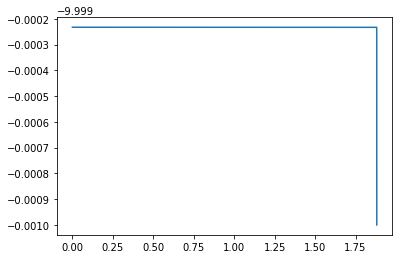

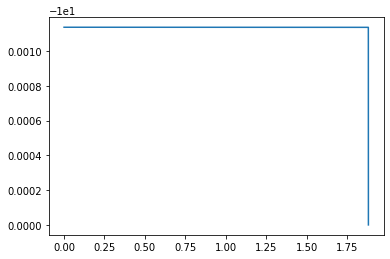

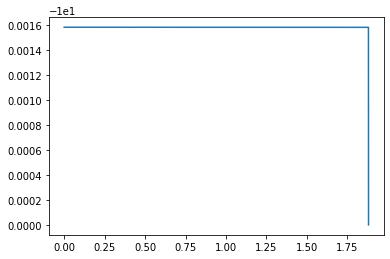

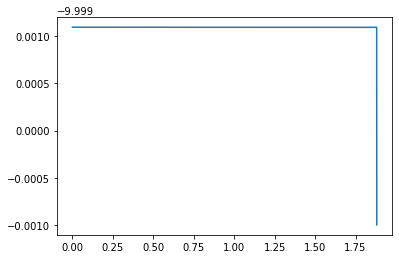

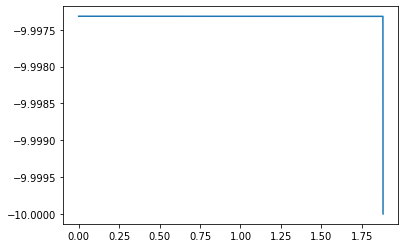

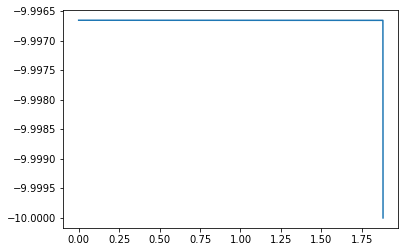

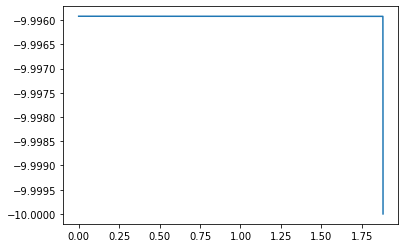

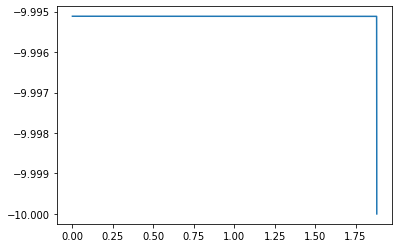

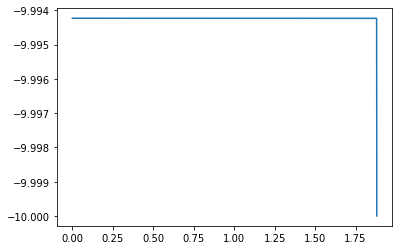

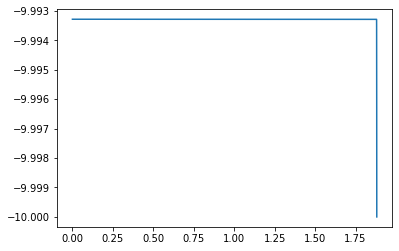

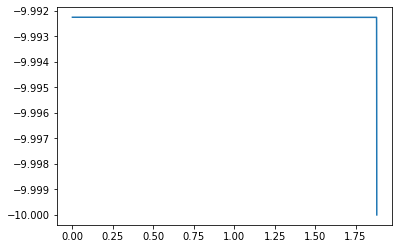

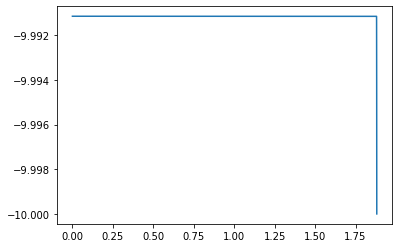

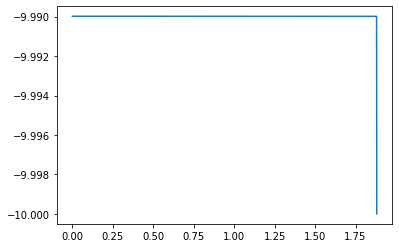

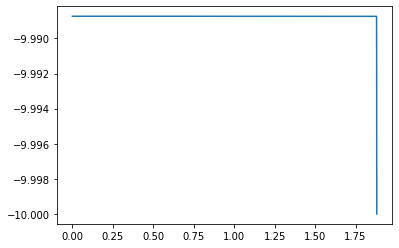

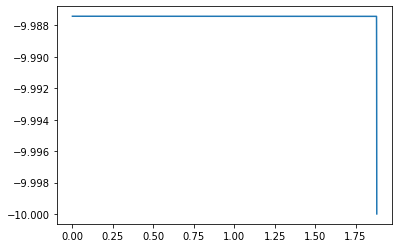

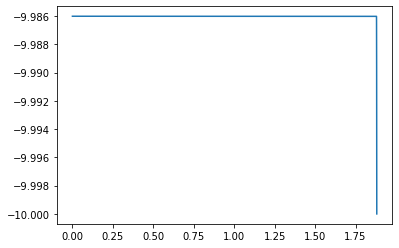

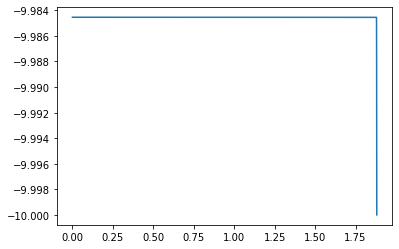

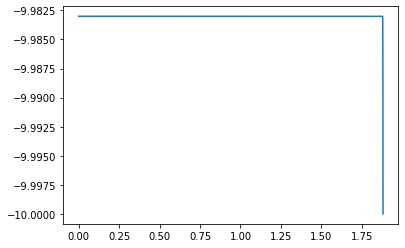

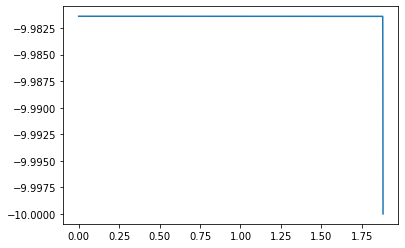

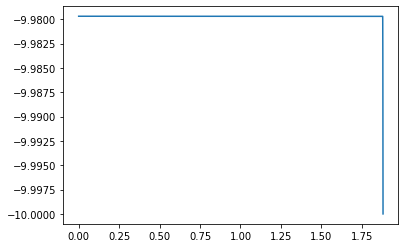

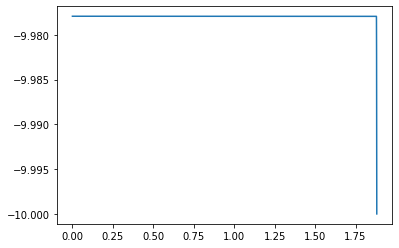

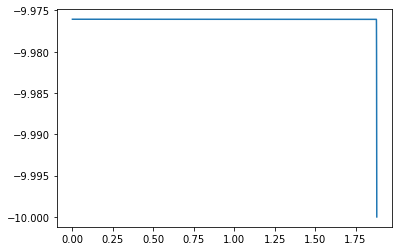

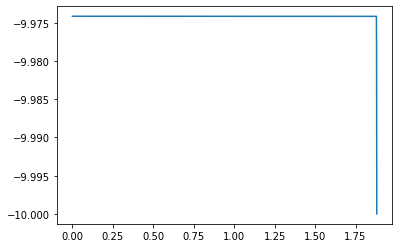

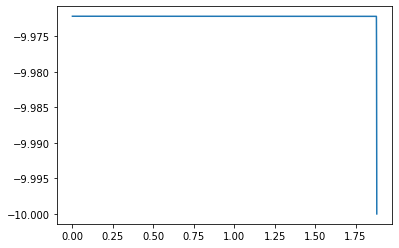

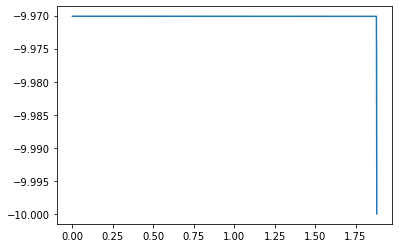

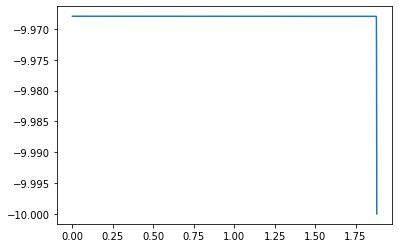

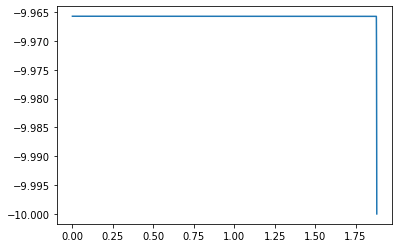

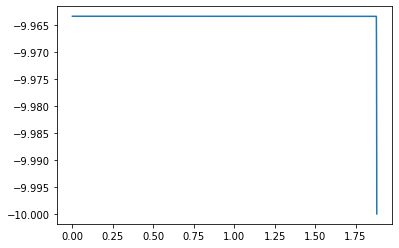

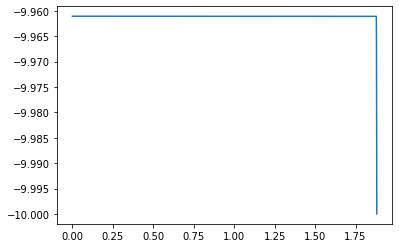

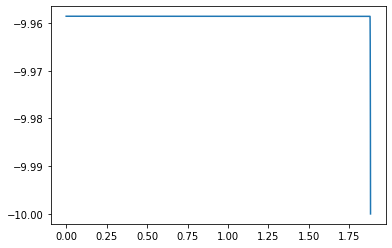

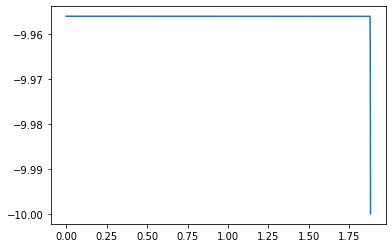

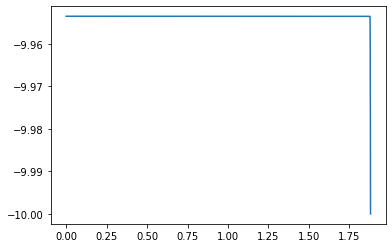

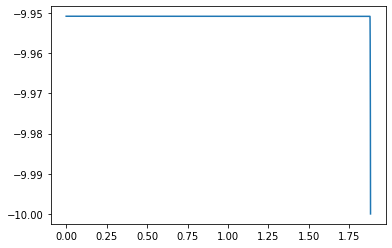

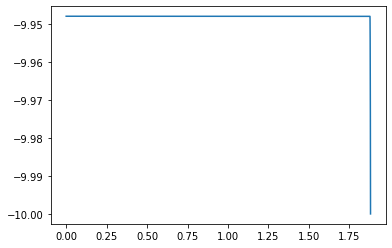

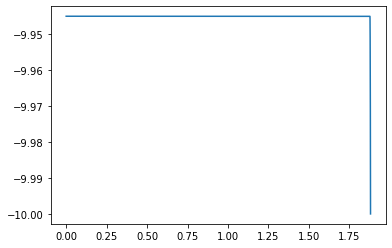

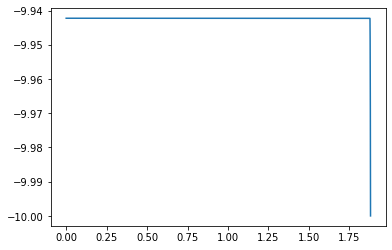

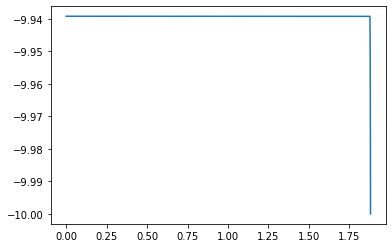

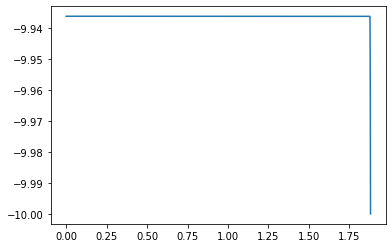

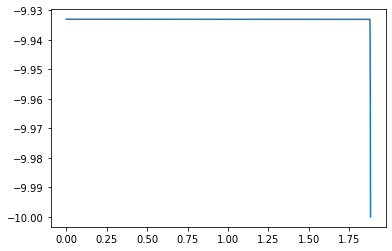

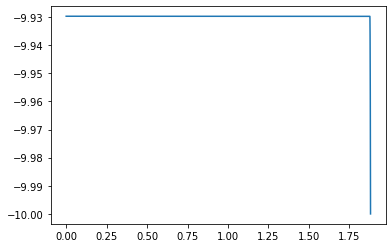

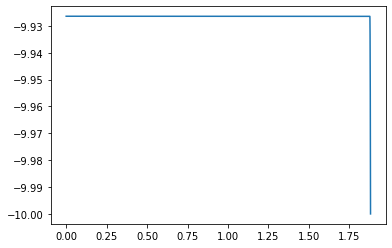

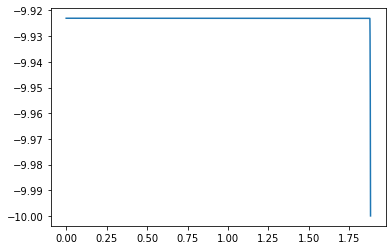

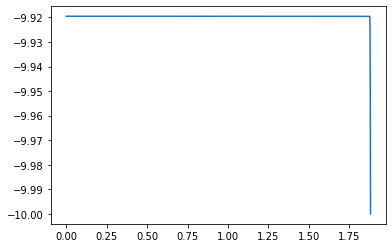

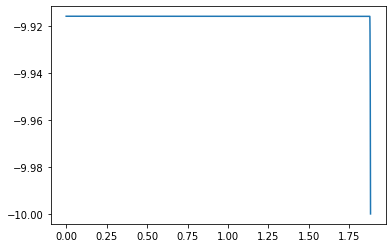

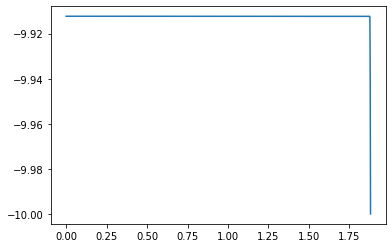

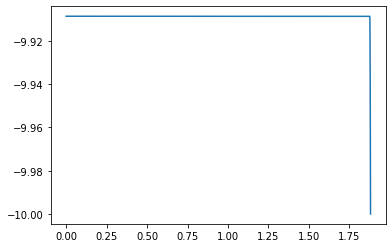

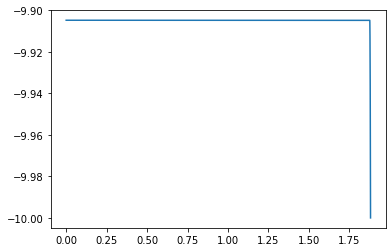

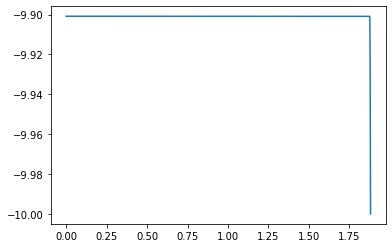

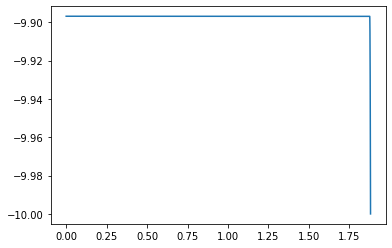

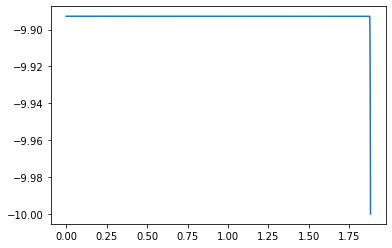

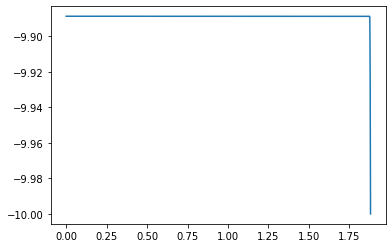

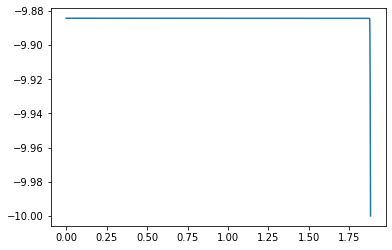

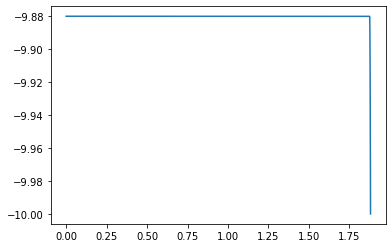

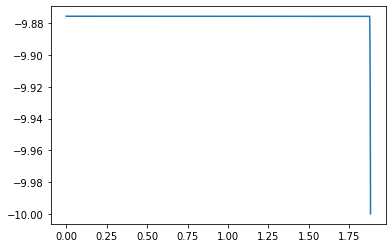

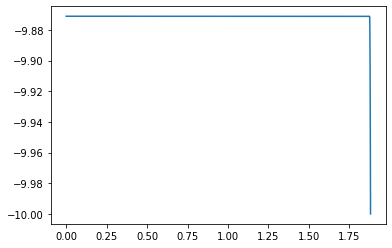

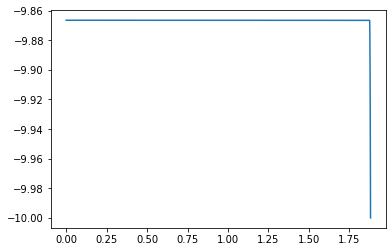

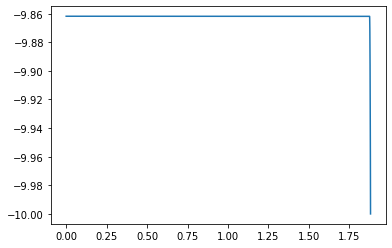

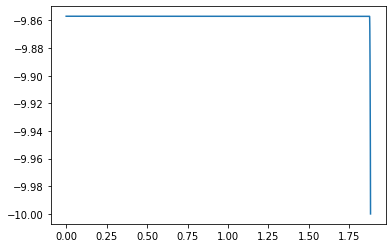

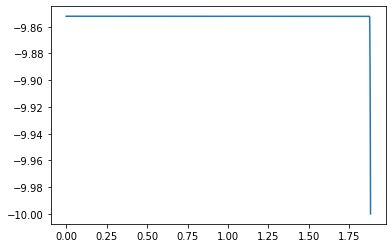

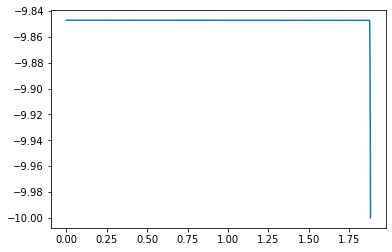

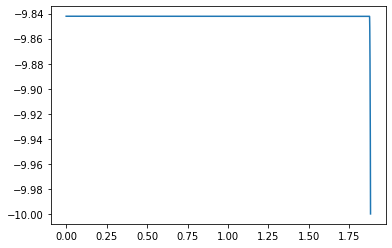

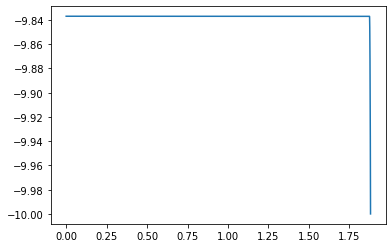

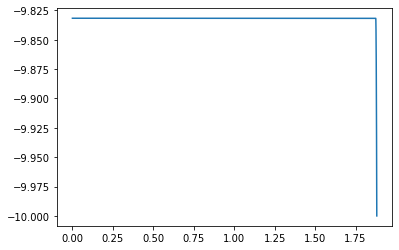

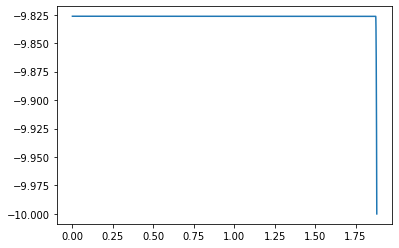

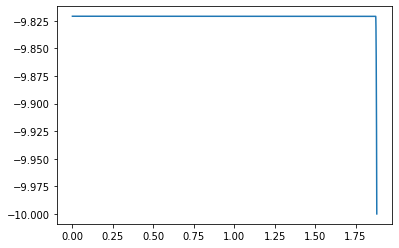

In [285]:
E_init_kT = -10
dF = get_E_dot_init_kT(film, E_init_kT, do_plot=True)

# Calculate the shape of eV(x) for different start values V(x=Surface) between -10 and +10 kt

In [9]:
def get_init_values(film, kT_min=-10, kT_max=10, count=11):
    dF = pd.DataFrame()
    film.set_calc_mode()
    for E_init_kT in linspace(kT_min,kT_max,count):
        print(E_init_kT)
        ser_temp = pd.Series(name = E_init_kT)
        ser_temp['E_init_kT'] = E_init_kT

        E_dot_init_kT, data = get_E_dot_init_kT(film, E_init_kT)
        ser_temp['E_dot_init_kT'] = E_dot_init_kT
        ser_temp['ivp_sol'] = data

        dF = dF.append(ser_temp)

    if are_all_sol_ok(dF):
        print('Found solutions for all IVPs')
        pass
    else:
        print('Some IVP could not be solved.')
        display(dF.apply(lambda r:r['ivp_sol']['success'], axis=1))
    return dF

def are_all_sol_ok(dF):
    return dF.apply(lambda r:r['ivp_sol']['success'], axis=1).all()

def plot_ivp_solutions(dF):
    fig, axe = subplots(figsize = ((1+5**0.5)/2*9,9))
    for ax_i, (row_i, row) in enumerate(dF.iterrows()):
        data = row['sol_cleaned']
        r = data['r']
        E_kT = data['eV']
        E_dot_kT = data['eV_dot']
        axe.plot(r,E_kT)
        axe.set_title(f'{row["E_init_kT"]} {row["E_dot_init_kT"]}')
    return fig, axe

def add_res_to_dF(dF, film):
    film.set_calc_mode()
    for row_i,row in dF.iterrows():
        E_dot_init_kT = row['E_dot_init_kT']
        E_init_kT = row['E_init_kT']
        data = row['ivp_sol']
        r = data.t
        v = data.y[0]
        v_dot = data.y[1]
        
        E_dot_init = film.material.kT_to_J(E_dot_init_kT)
        E_init = film.material.kT_to_J(E_init_kT)
        #print(E_init_kT)

        #film.set_lookup_mode()
        r,v,v_dot,data = film.solve_with_values(E_init,E_dot_init)
        min_index = np.argmin(abs(v_dot))
        v[min_index:]=v[min_index]
        v_dot[min_index:]=v_dot[min_index]
        #fig, axes = subplots(2, sharex=True)
        #axe = axes[0]
        #axe.plot(r,v)
        v_E = film.material.kT_to_J(v)
        charges = [film.material.n(vv)[0] for vv in v_E]
        total_charges = np.trapz(charges,-r)*film.material.LD
        #axe = axes[1]
        #axe.plot(r, charges)
        #print('TC: ',total_charges)
        #print(min(r), max(r))
        #print()
        sol_data_cleaned = {}
        sol_data_cleaned['eV'] = v
        sol_data_cleaned['eV_dot'] = v_dot
        sol_data_cleaned['r'] = r
        dF.loc[row_i,'TotCharges'] = total_charges
        dF.loc[row_i,'n_average'] = total_charges/film.D
        dF.loc[row_i,'sol_cleaned'] = [sol_data_cleaned]
    dF['res'] = dF['TotCharges']/dF.loc[0.0]['TotCharges']
    return dF


In [17]:
E_EF_EC_diff = 0.400
thickness = 200e-9

mat = Material(300,DIFF_EF_EC_evolt=E_EF_EC_diff,mass_e_eff_factor=0.275,EPSILON=12)
film = FILM(thickness, mat)


Min index is: 10000 of 10000
-4605910.973146945 -7.357588823428847 1
-4605910.973146945
r          1.881321e+00
v         -2.000000e+01
v_dot     -7.357589e+00
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.8


Min index is: 10000 of 10000
-4605891.999736241 -8.157588823428847 0.8
-4605891.999736241
r          1.881321e+00
v         -2.000000e+01
v_dot     -8.157589e+00
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000
-4605350.185207183 -32.157588823428846 0.8
-4605350.185207183
r          1.881321e+00
v         -2.000000e+01
v_dot     -3.215759e+01
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000
-4604769.435303047 -56.157588823428846 0.8
-4604769.435303047
r          1.881321e+00
v         -2.000000e+01
v_dot     -5.615759e+01
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000
-4604146.2820045315 -80.15758882342885 0.8
-4

/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4589653.43740823 -488.15758882342885 0.8
-4589653.43740823
r          1.881321e+00
v         -2.000000e+01
v_dot     -4.881576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4588401.099461445 -512.1575888234288 0.8
-4588401.099461445
r          1.881321e+00
v         -2.000000e+01
v_dot     -5.121576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4587074.278113897 -536.1575888234288 0.8
-4587074.278113897
r          1.881321e+00
v         -2.000000e+01
v_dot     -5.361576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4585665.328613482 -560.1575888234288 0.8
-4585665.328613482
r          1.881321e+00
v         -2.000000e+01
v_dot     -5.601576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4584164.327136786 -584.1575888234288 0.8
-4584164.327136786
r          1.881321e+00
v         -2.000000e+01
v_dot     -5.841576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4582557.916017002 -608.1575888234288 0.8
-4582557.916017002
r          1.881321e+00
v         -2.000000e+01
v_dot     -6.081576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4580831.94527787 -632.1575888234288 0.8
-4580831.94527787
r          1.881321e+00
v         -2.000000e+01
v_dot     -6.321576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4578968.325217816 -656.1575888234288 0.8
-4578968.325217816
r          1.881321e+00
v         -2.000000e+01
v_dot     -6.561576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4576962.696591269 -680.1575888234288 0.8
-4576962.696591269
r          1.881321e+00
v         -2.000000e+01
v_dot     -6.801576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4574796.910833042 -704.1575888234288 0.8
-4574796.910833042
r          1.881321e+00
v         -2.000000e+01
v_dot     -7.041576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4572401.1886624 -728.1575888234288 0.8
-4572401.1886624
r          1.881321e+00
v         -2.000000e+01
v_dot     -7.281576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4569715.3650655905 -752.1575888234288 0.8
-4569715.3650655905
r          1.881321e+00
v         -2.000000e+01
v_dot     -7.521576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4566713.947892666 -776.1575888234288 0.8
-4566713.947892666
r          1.881321e+00
v         -2.000000e+01
v_dot     -7.761576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4563341.720673534 -800.1575888234288 0.8
-4563341.720673534
r          1.881321e+00
v         -2.000000e+01
v_dot     -8.001576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4559456.692575464 -824.1575888234288 0.8
-4559456.692575464
r          1.881321e+00
v         -2.000000e+01
v_dot     -8.241576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4554899.727078238 -848.1575888234288 0.8
-4554899.727078238
r          1.881321e+00
v         -2.000000e+01
v_dot     -8.481576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4549419.899994807 -872.1575888234288 0.8
-4549419.899994807
r          1.881321e+00
v         -2.000000e+01
v_dot     -8.721576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4542551.0388163775 -896.1575888234288 0.8
-4542551.0388163775
r          1.881321e+00
v         -2.000000e+01
v_dot     -8.961576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4533376.175637124 -920.1575888234287 0.8
-4533376.175637124
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.201576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4520056.556073777 -944.1575888234288 0.8
-4520056.556073777
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.441576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4496874.563013586 -968.1575888234287 0.8
-4496874.563013586
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.681576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4420566.917635515 -992.1575888234288 0.8
-4420566.917635515
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.921576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 5330 of 5330


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-844.4017566528265 -1016.1575888234287 0.8
-844.4017566528265
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.016158e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.6400000000000001


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4342373.8240455855 -996.9575888234288 0.6400000000000001
-4342373.8240455855
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.969576e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.5120000000000001


Min index is: 5472 of 5472


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-863.945510220304 -1012.3175888234287 0.5120000000000001
-863.945510220304
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.012318e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.40960000000000013


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-908037.9727298191 -1000.0295888234288 0.40960000000000013
-908037.9727298191
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000030e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.32768000000000014


Min index is: 5589 of 5589


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-878.4167326001683 -1009.8599888234289 0.32768000000000014
-878.4167326001683
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.009860e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.2621440000000001


Min index is: 6419 of 6419


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-949.6766081686806 -1001.9956688234289 0.2621440000000001
-949.6766081686806
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.001996e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4399663.063917914 -994.1313488234287 0.2621440000000001
-4399663.063917914
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.941313e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.2097152000000001


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4396869.979856603 -994.3410640234287 0.2097152000000001
-4396869.979856603
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.943411e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 7023 of 7023


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-976.9526444424578 -1000.6325200234287 0.2097152000000001
-976.9526444424578
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000633e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.1677721600000001


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4376451.189352814 -995.5993552234288 0.1677721600000001
-4376451.189352814
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.955994e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.13421772800000006


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4373788.29099904 -995.7335729514288 0.13421772800000006
-4373788.29099904
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.957336e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-3891193.6049637734 -999.7601047914287 0.13421772800000006
-3891193.6049637734
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.997601e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 6086 of 6086


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-926.9885838490156 -1003.7866366314288 0.13421772800000006
-926.9885838490156
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.003787e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.10737418240000006


Min index is: 7083 of 7083


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-978.9290398011266 -1000.5654111594287 0.10737418240000006
-978.9290398011266
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000565e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 7197 of 7197


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-982.3831683095414 -1000.4580369770287 0.10737418240000006
-982.3831683095414
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000458e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 7343 of 7343


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-986.3286196921026 -1000.3506627946286 0.10737418240000006
-986.3286196921026
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000351e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 7549 of 7549


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-991.0507300499373 -1000.2432886122286 0.10737418240000006
-991.0507300499373
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000243e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 7901 of 7901


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-997.3079684302511 -1000.1359144298286 0.10737418240000006
-997.3079684302511
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000136e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1126289.9867644978 -1000.0285402474286 0.10737418240000006
-1126289.9867644978
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000029e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.08589934592000005


Min index is: 8016 of 8016


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-998.9337433517039 -1000.1144395933486 0.08589934592000005
-998.9337433517039
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000114e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.06871947673600004


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4293322.959343055 -998.0528552912687 0.06871947673600004
-4293322.959343055
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.980529e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.054975581388800036


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-4289839.861966782 -998.1078308726574 0.054975581388800036
-4289839.861966782
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.981078e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 10000 of 10000


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-3894595.306775344 -999.7570983143215 0.054975581388800036
-3894595.306775344
r          1.881321e+00
v         -2.000000e+01
v_dot     -9.997571e+02
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 6602 of 6602


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-959.5459556198634 -1001.4063657559856 0.054975581388800036
-959.5459556198634
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.001406e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.043980465111040035


Min index is: 8216 of 8216


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1001.3911736809787 -1000.0869518026544 0.043980465111040035
-1001.3911736809787
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000087e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.03518437208883203


Min index is: 7972 of 7972


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-998.3278042997748 -1000.1221361747433 0.03518437208883203
-998.3278042997748
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000122e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.028147497671065627


Min index is: 8157 of 8157


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.7086022354257 -1000.0939886770722 0.028147497671065627
-1000.7086022354257
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000094e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.022517998136852502


Min index is: 8003 of 8003


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-998.7681550505177 -1000.1165066752089 0.022517998136852502
-998.7681550505177
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000117e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.018014398509482003


Min index is: 8122 of 8122


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.2935405255964 -1000.0984922766996 0.018014398509482003
-1000.2935405255964
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000098e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.014411518807585602


Min index is: 8025 of 8025


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-999.0582057895962 -1000.1129037955071 0.014411518807585602
-999.0582057895962
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000113e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.011529215046068483


Min index is: 8101 of 8101


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.0357913123557 -1000.1013745804611 0.011529215046068483
-1000.0357913123557
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8191 of 8191


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1001.1050814504465 -1000.0898453654149 0.011529215046068483
-1001.1050814504465
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000090e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.009223372036854787


Min index is: 8118 of 8118


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.2415180555142 -1000.0990687374521 0.009223372036854787
-1000.2415180555142
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000099e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8054 of 8054


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-999.4396944613651 -1000.1082921094888 0.009223372036854787
-999.4396944613651
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000108e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.00737869762948383


Min index is: 8104 of 8104


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.076639525961 -1000.1009134118593 0.00737869762948383
-1000.076639525961
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8160 of 8160


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.7513293834621 -1000.0935347142297 0.00737869762948383
-1000.7513293834621
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000094e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.005902958103587064


Min index is: 8115 of 8115


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.2083494368757 -1000.0994376723334 0.005902958103587064
-1000.2083494368757
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000099e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8073 of 8073


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-999.6903375287637 -1000.1053406304369 0.005902958103587064
-999.6903375287637
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000105e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.004722366482869652


Min index is: 8106 of 8106


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.102859368793 -1000.1006182639541 0.004722366482869652
-1000.102859368793
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0037778931862957215


Min index is: 8080 of 8080


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-999.7716788070434 -1000.1043961571404 0.0037778931862957215
-999.7716788070434
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000104e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0030223145490365774


Min index is: 8101 of 8101


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.0358565502731 -1000.1013738425912 0.0030223145490365774
-1000.0358565502731
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8123 of 8123


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.3062790893994 -1000.0983515280423 0.0030223145490365774
-1000.3062790893994
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000098e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.002417851639229262


Min index is: 8105 of 8105


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.0894272996238 -1000.1007693796815 0.002417851639229262
-1000.0894272996238
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0019342813113834097


Min index is: 8119 of 8119


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.2625732048209 -1000.0988350983702 0.0019342813113834097
-1000.2625732048209
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000099e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0015474250491067279


Min index is: 8108 of 8108


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.1238455640051 -1000.1003825234192 0.0015474250491067279
-1000.1238455640051
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000100e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8097 of 8097


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-999.9867917311767 -1000.1019299484685 0.0015474250491067279
-999.9867917311767
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000102e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0012379400392853823


Min index is: 8106 of 8106


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.0963029222231 -1000.1006920084292 0.0012379400392853823
-1000.0963029222231
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8115 of 8115


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.206877698256 -1000.09945406839 0.0012379400392853823
-1000.206877698256
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000099e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0009903520314283058


Min index is: 8108 of 8108


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.1183318640565 -1000.1004444204214 0.0009903520314283058
-1000.1183318640565
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000100e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64


Min index is: 8100 of 8100


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.0304699259083 -1000.1014347724528 0.0009903520314283058
-1000.0304699259083
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0007922816251426447


Min index is: 8106 of 8106


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


-1000.1007050431159 -1000.1006424908275 0.0007922816251426447
-1000.1007050431159
r          1.881321e+00
v         -2.000000e+01
v_dot     -1.000101e+03
charges    2.977381e+26
Name: 1.881320513817304, dtype: float64
Shrink to 0.0006338253001141158


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


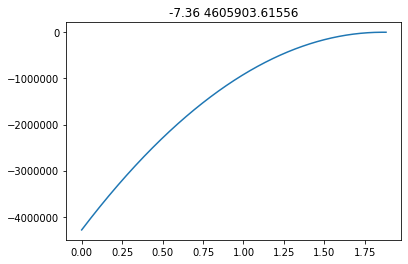

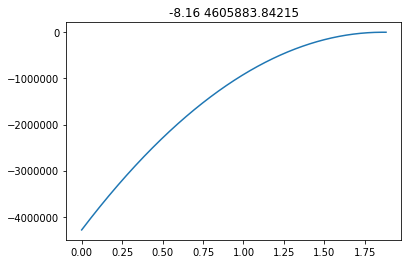

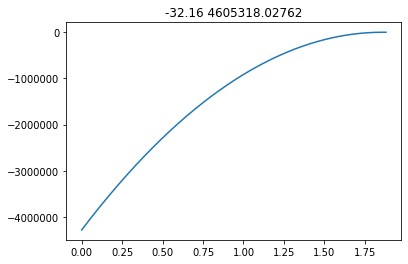

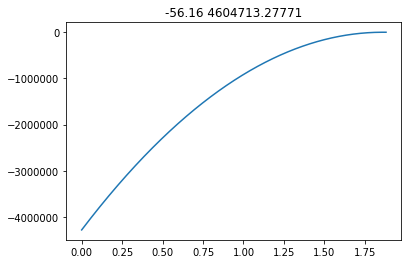

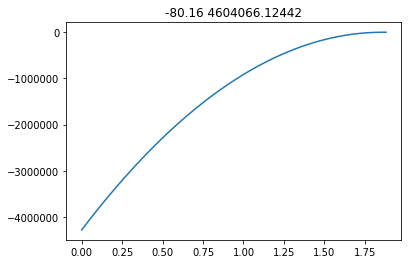

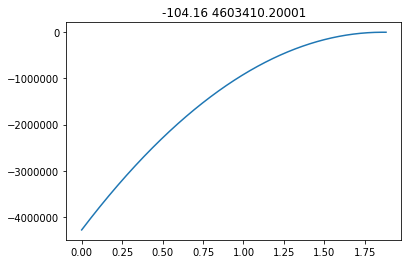

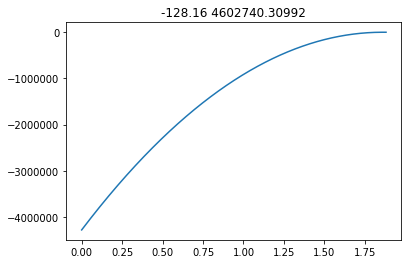

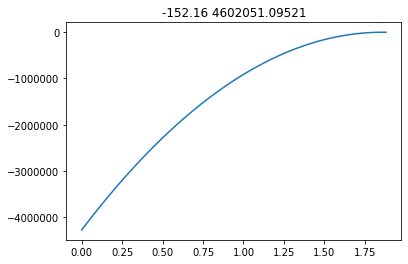

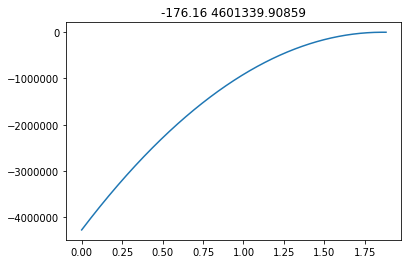

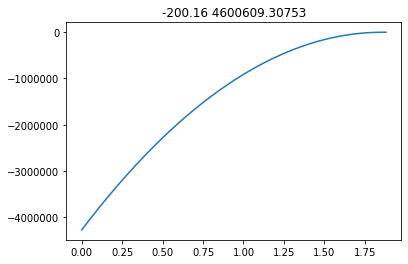

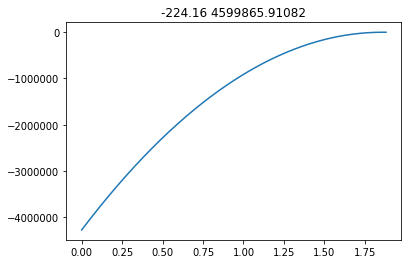

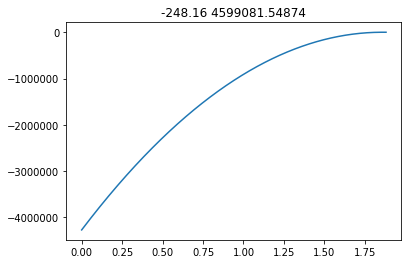

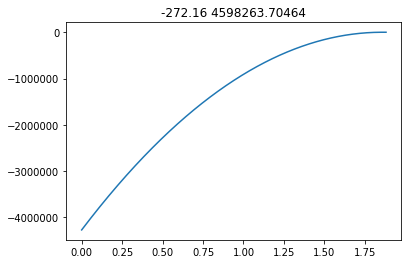

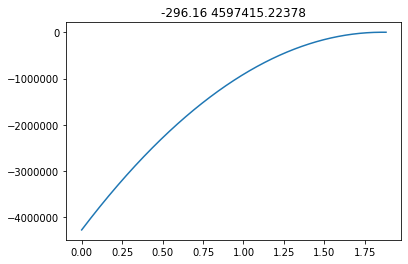

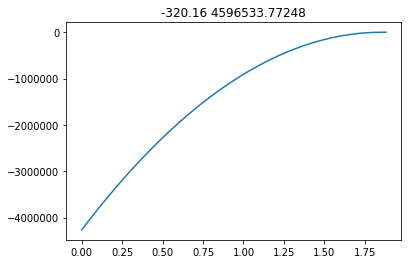

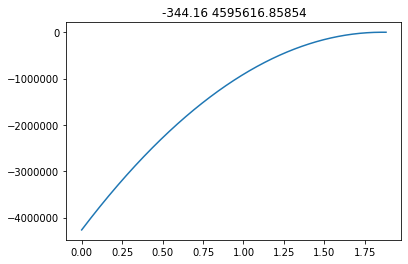

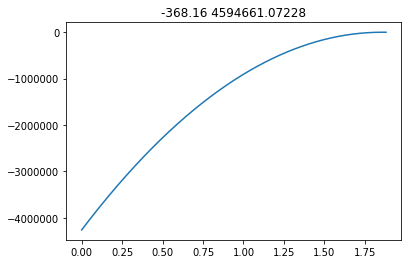

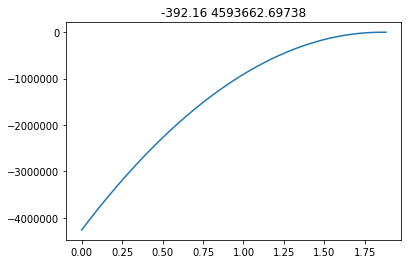

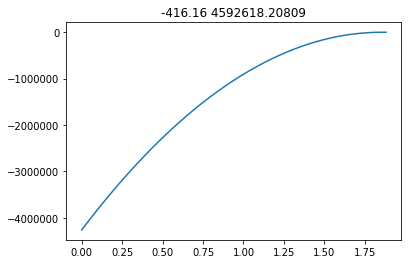

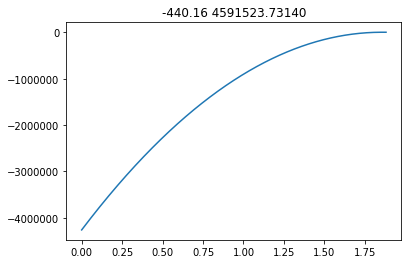

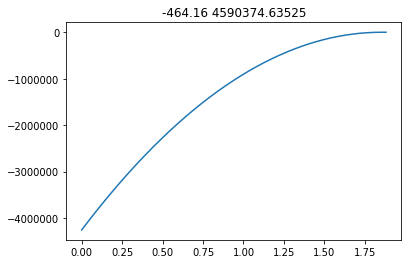

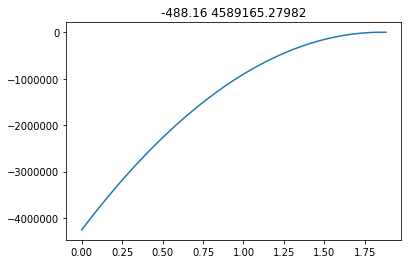

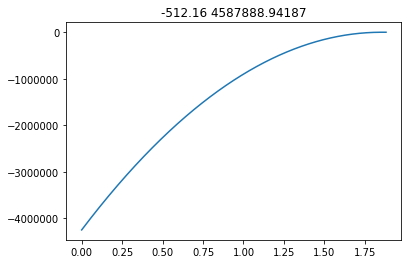

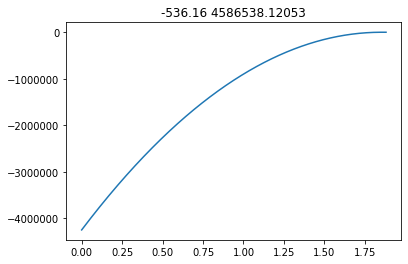

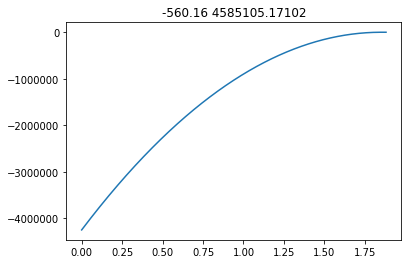

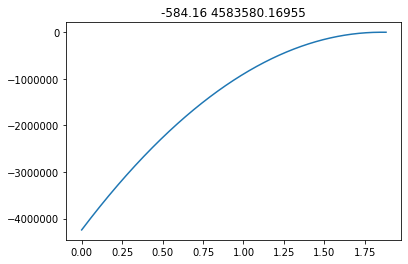

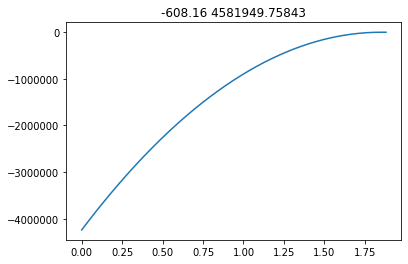

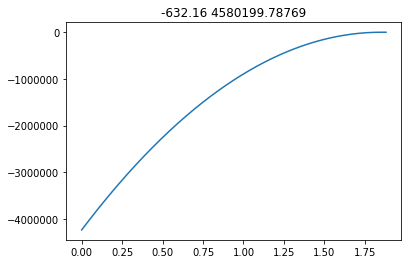

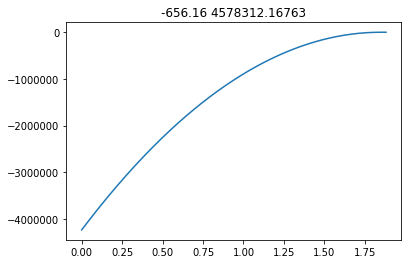

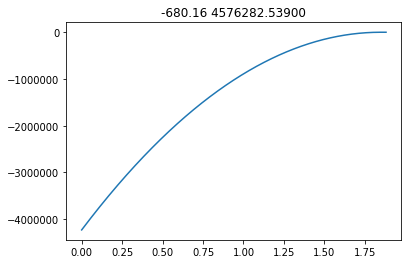

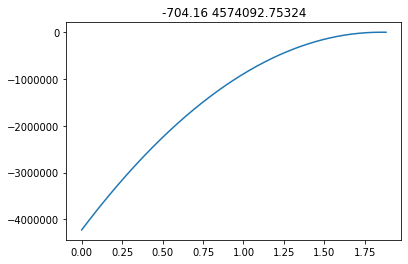

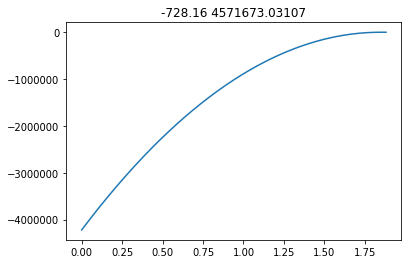

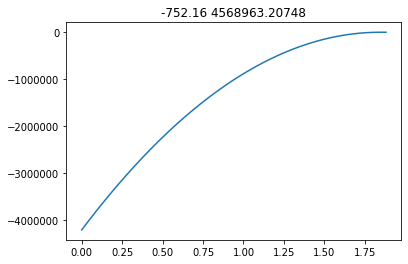

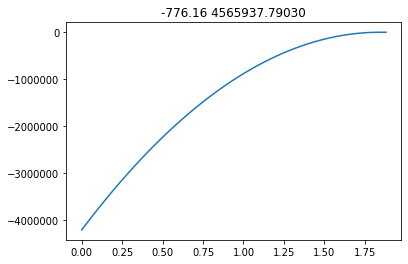

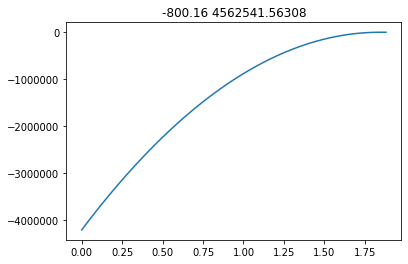

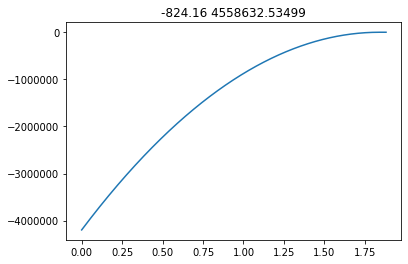

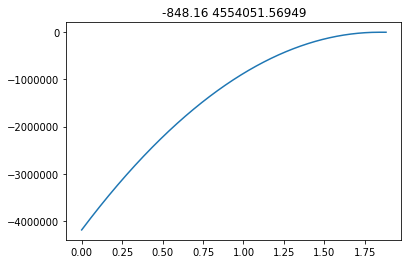

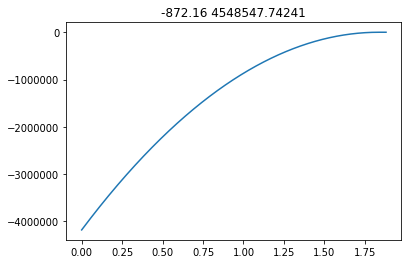

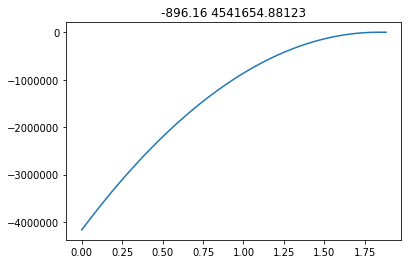

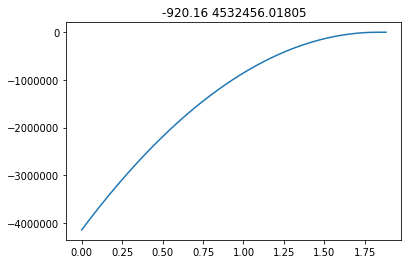

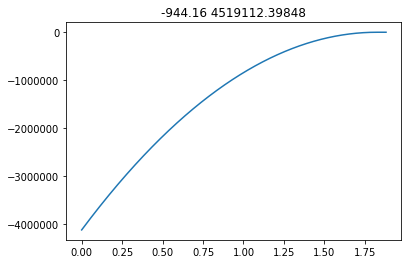

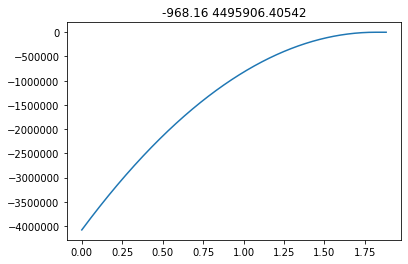

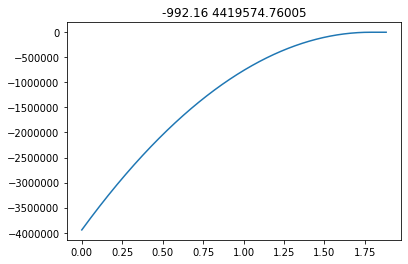

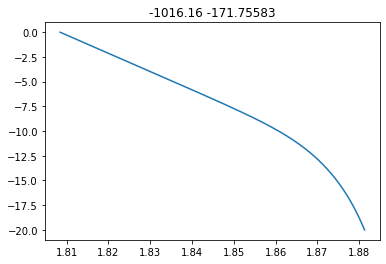

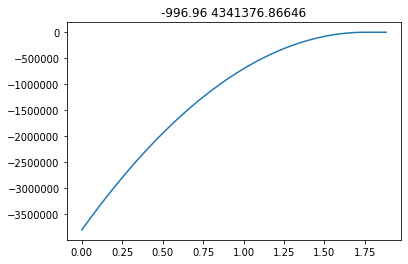

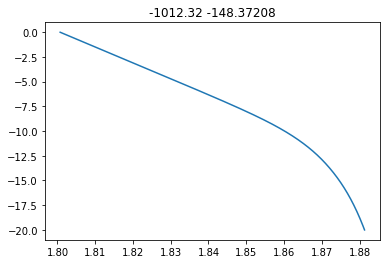

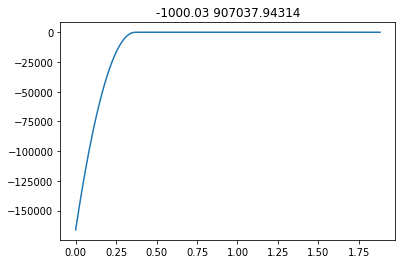

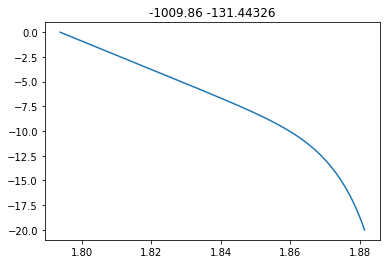

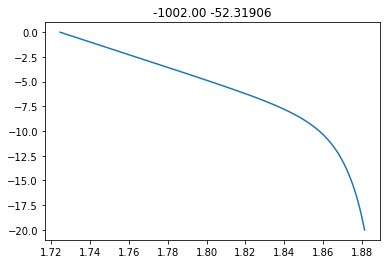

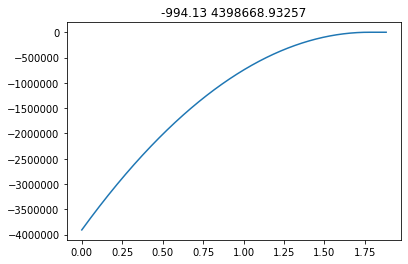

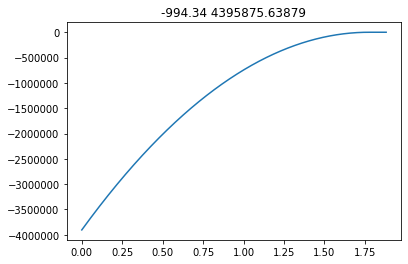

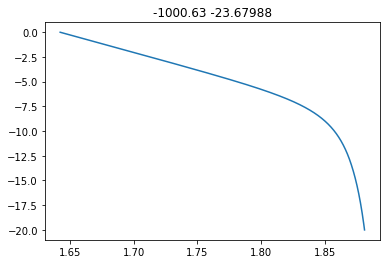

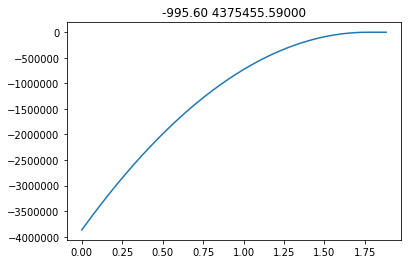

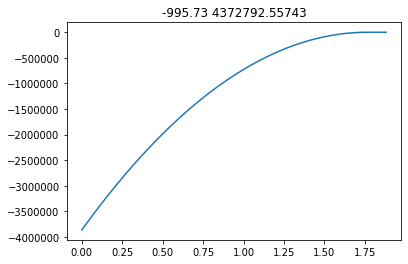

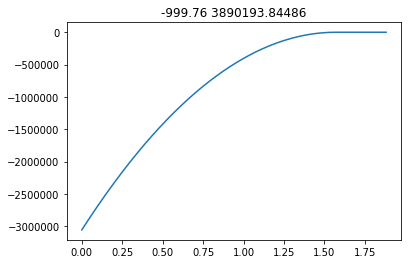

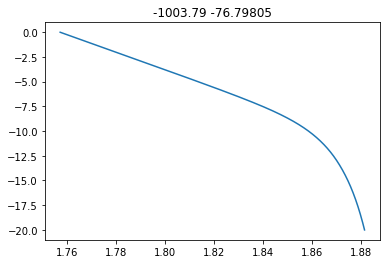

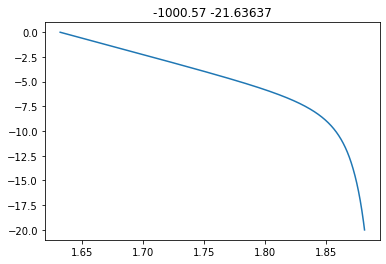

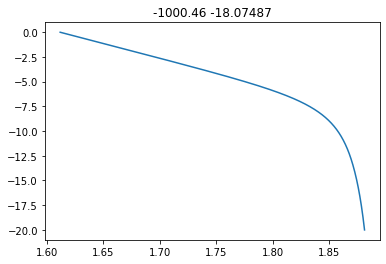

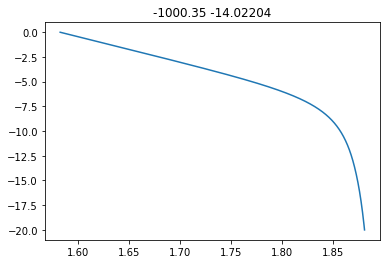

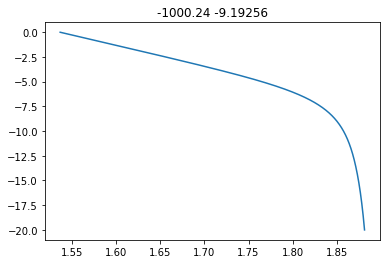

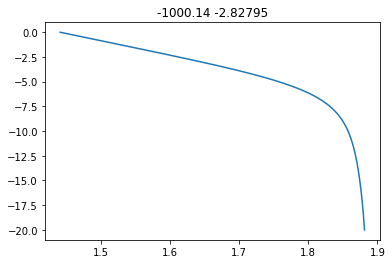

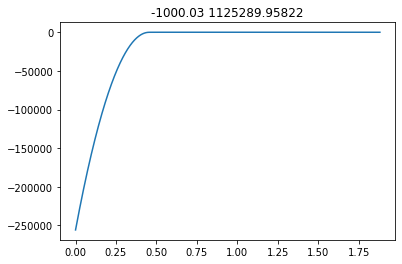

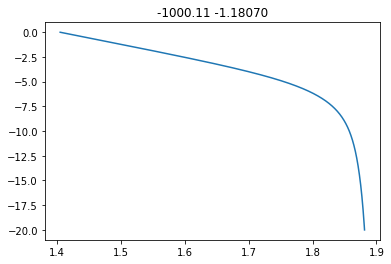

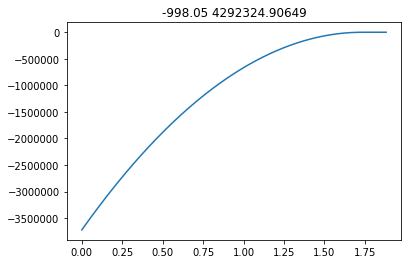

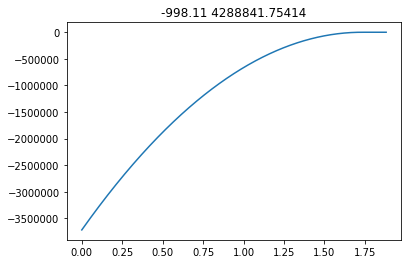

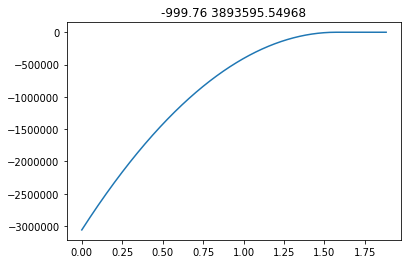

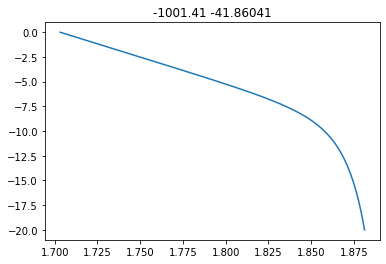

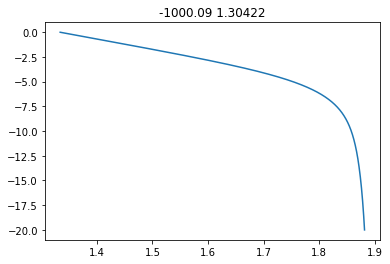

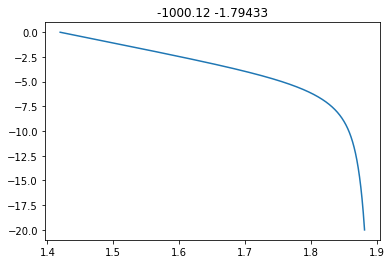

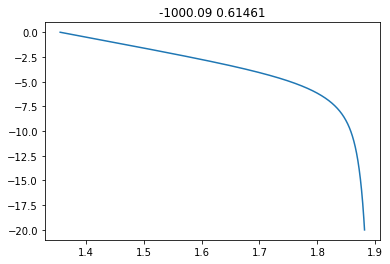

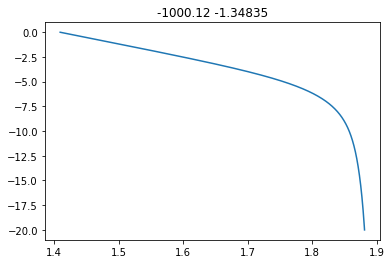

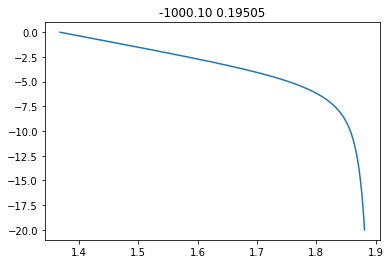

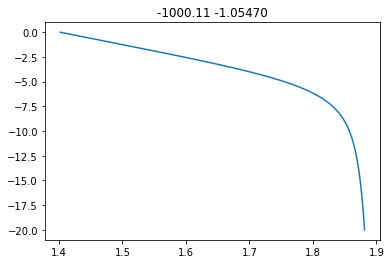

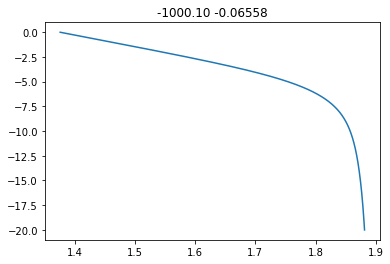

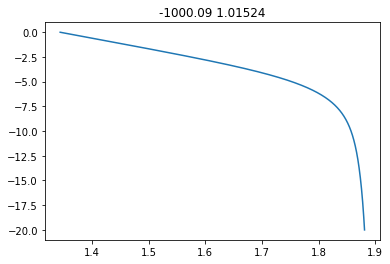

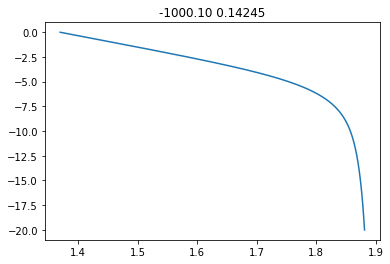

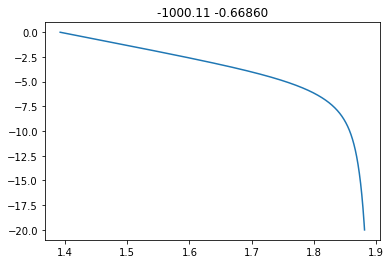

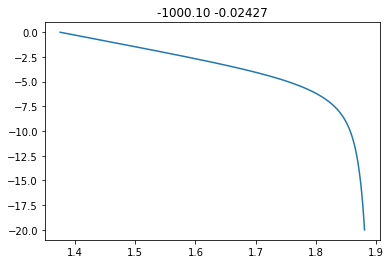

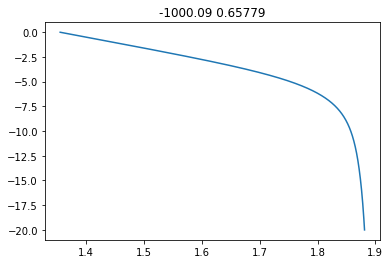

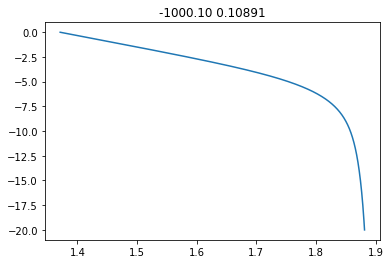

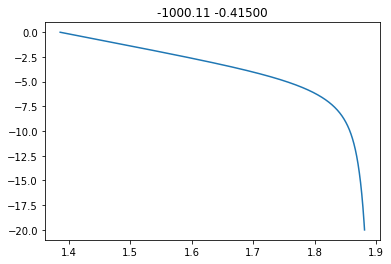

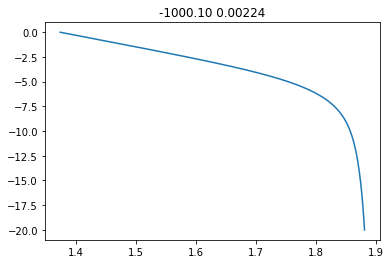

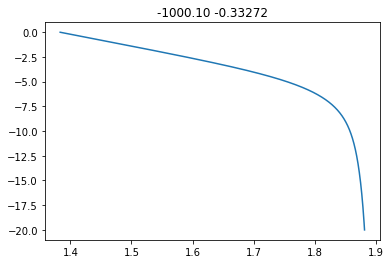

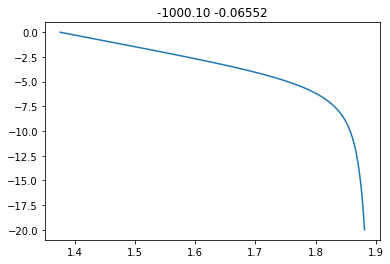

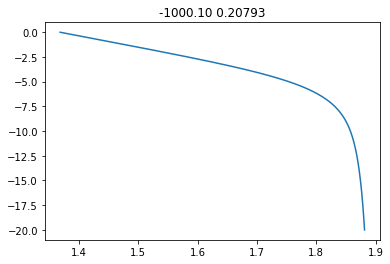

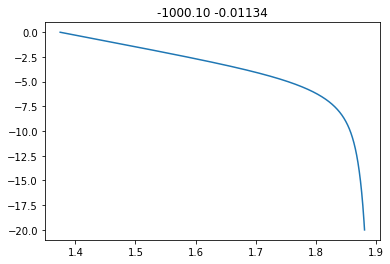

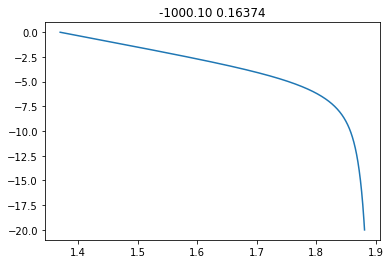

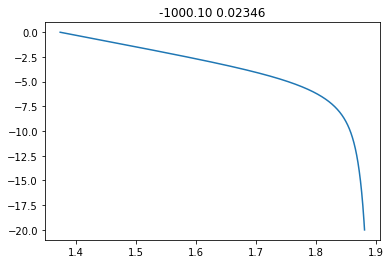

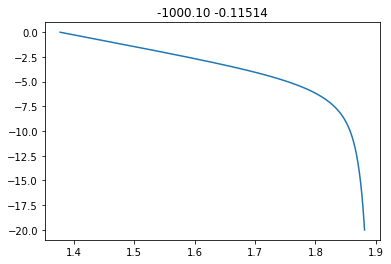

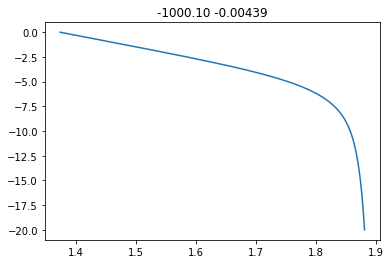

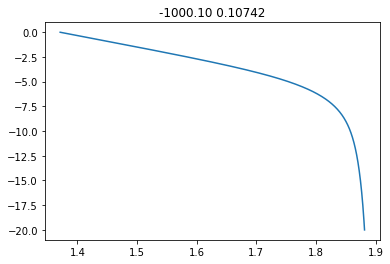

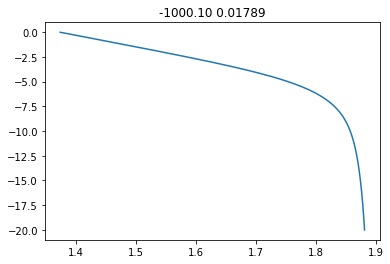

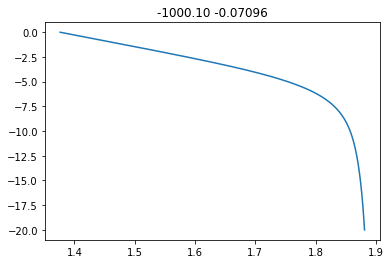

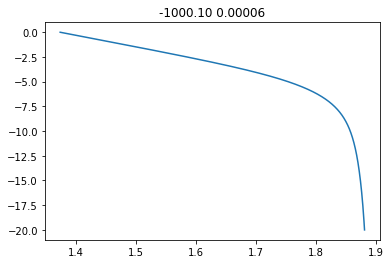

In [18]:
E_dot_init_kT, data = get_E_dot_init_kT(film, -20, do_plot=True)

Calc. for 200.0nm with EC_EF = 0.005
-20.0
-17.142857142857142
-14.285714285714285
-11.428571428571429
-8.571428571428571
-5.7142857142857135
-2.8571428571428577
0.0
Tune min index
shrink mode switch 10
2.8571428571428577
5.714285714285715
8.571428571428573
11.42857142857143
14.285714285714285
17.142857142857146
20.0
Found solutions for all IVPs


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'EC_EF_0.0050eV_200.00nm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


Calc. for 200.0nm with EC_EF = 0.10375000000000001
-20.0
-17.142857142857142
-14.285714285714285
-11.428571428571429
-8.571428571428571
-5.7142857142857135
-2.8571428571428577
0.0
Tune min index
shrink mode switch 10
2.8571428571428577
5.714285714285715
8.571428571428573
11.42857142857143
14.285714285714285
17.142857142857146
20.0
Found solutions for all IVPs
Calc. for 200.0nm with EC_EF = 0.2025


/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/tables/path.py:157: NaturalNameWarning: object name is not a valid Python identifier: 'EC_EF_0.1038eV_200.00nm'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/peterb/.local/share/virtualenvs/thesis-bdtQKVfw/lib/python3.7/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


-20.0
Tune min index
shrink mode switch 7.897302230536021e-05
shrink 6.317841784428818e-05
Tune min index
shrink 5.054273427543054e-05
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min index
Tune min i

KeyboardInterrupt: 

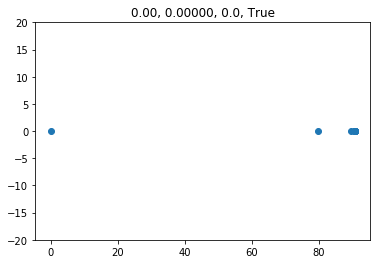

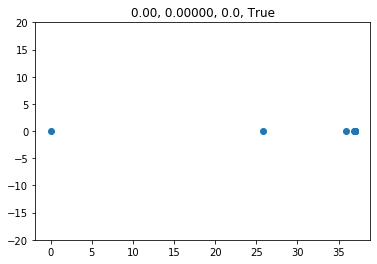

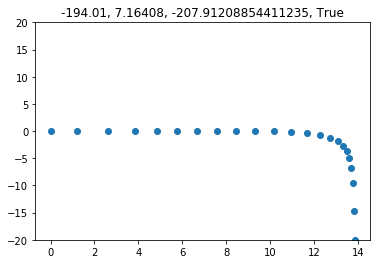

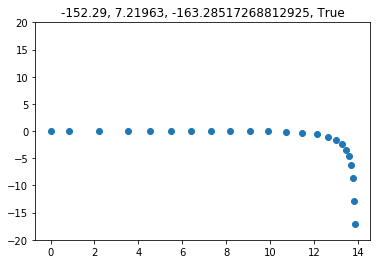

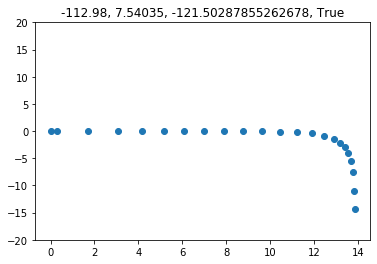

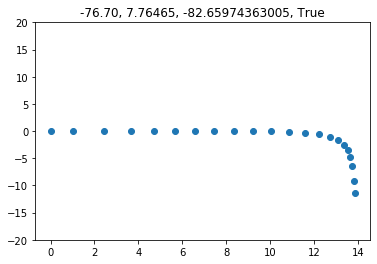

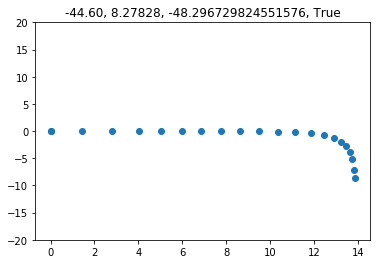

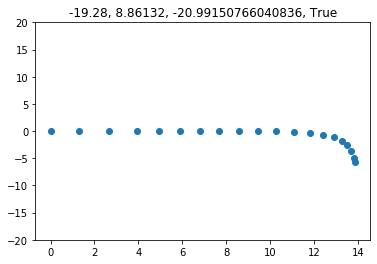

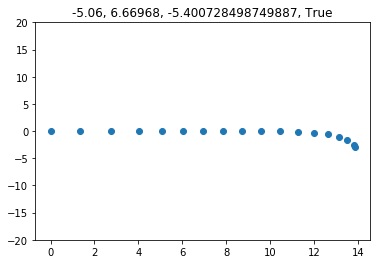

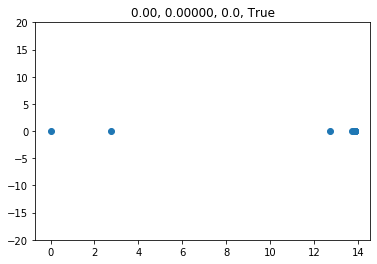

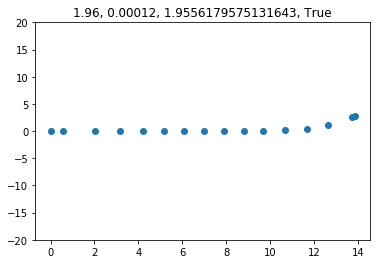

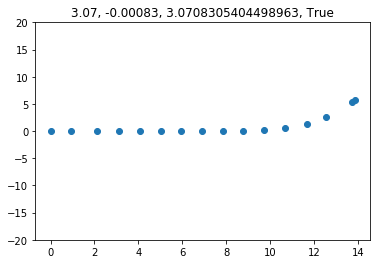

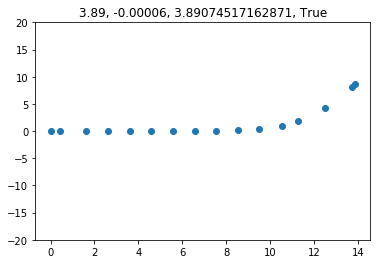

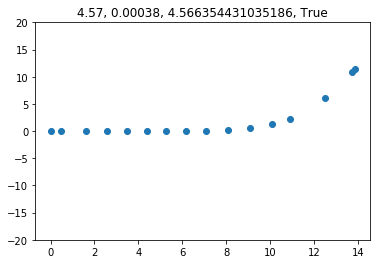

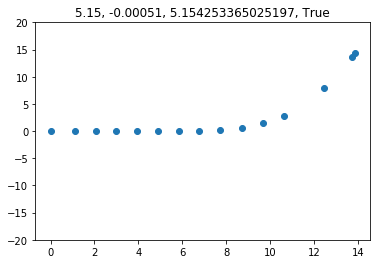

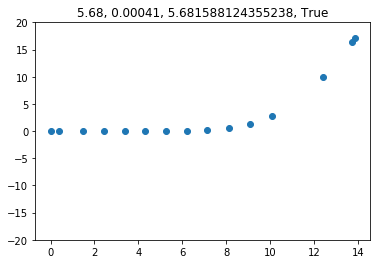

In [11]:
                      
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

for E_EF_EC_diff in linspace(0.005,0.400, 5):
#for E_EF_EC_diff in [0.285]:
    mat = Material(300,DIFF_EF_EC_evolt=E_EF_EC_diff,mass_e_eff_factor=0.275,EPSILON=12)
    thickness = 200e-9
    print(f'Calc. for {thickness*1e9}nm with EC_EF = {E_EF_EC_diff}')
    film = FILM(thickness, mat)

    dF = get_init_values(film, kT_min=-20, kT_max=20, count=15)
    dF = add_res_to_dF(dF,film)


    s = pd.Series(name = E_EF_EC_diff)
    s['film']=film
    s['material']=mat
    s['dF'] = dF
    s['all_ok'] = are_all_sol_ok(dF)
    s['EC_EF_eV'] = E_EF_EC_diff
    s['thickness'] = thickness
    s.to_hdf('sol_dF_fed_gauss_tuned.h5',f'EC_EF_{E_EF_EC_diff:.4f}eV_{thickness*1e9:.2f}nm', mode='a')

    #plot_material_char(mat)
    #plot_ivp_solutions(dF)
    #fig, axe = subplots()
    #axe.plot(dF['E_init_kT'],dF['res'])

In [216]:
%matplotlib qt5

In [217]:
plot_solutions(s)
fig, axe = subplots()
film = s['film']
mu = 75*10**-4#,  75 cm2/Vs
W_over_L = 1.03
dF = s['dF']
n_avergage = dF['n_average']
G = film.material.CONSTANTS.E_CHARGE*mu*W_over_L*n_avergage*film.D*1e6
axe.plot(s['dF']['E_init_kT'],G)
axe.set_yscale('log')
axe.set_ylim(1e-2, 1e4)

(0.01, 10000.0)

In [9]:
for s_i, s in total_dF.iterrows():
    plot_solutions(s)
    fig, axe = subplots()
    film = s['film']
    mu = 75*10**-4#,  75 cm2/Vs
    W_over_L = 1.03
    dF = s['dF']
    n_avergage = dF['n_average']
    G = film.material.CONSTANTS.E_CHARGE*mu*W_over_L*n_avergage*film.D*1e6
    axe.plot(s['dF']['E_init_kT'],G)
    axe.set_yscale('log')
    axe.set_ylim(1e-2, 1e4)

NameError: name 'total_dF' is not defined

In [194]:
for i in range(30):close()

In [14]:
store = pd.HDFStore('sol_dF_fed_gauss_tuned.h5', 'r')
ks = store.keys()
store[ks[0]]
store.close()

In [15]:
ks

['/EC_EF_0.0050eV_200.00nm', '/EC_EF_0.1038eV_200.00nm']

In [17]:
def plot_solutions(ser):
    fig, axe = subplots()
    film = s['film']
    D = film.D
    EC_EF = s['EC_EF_eV']
    
    for row_i, row in ser['dF'].iterrows():
        axe.set_title(f'{D*1e9}nm with EC_EF: {EC_EF}eV')
        eV = row['sol_cleaned']['eV']
        r = row['sol_cleaned']['r']
        axe.plot(r,eV)
    

    

In [42]:
%matplotlib inline

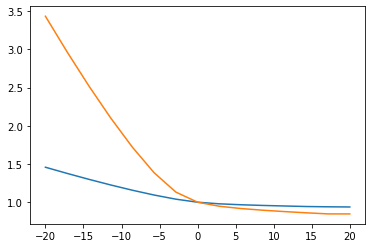

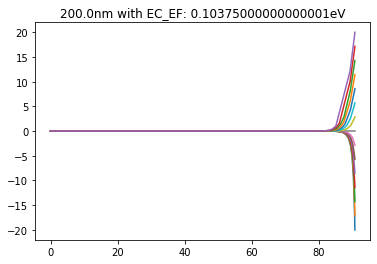

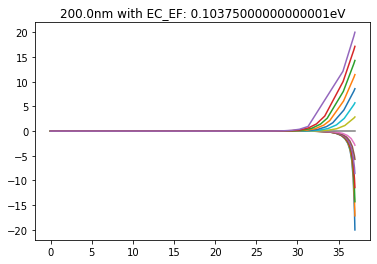

In [19]:
def load_hdf_entry(name):
    #ser = pd.read_hdf('sol_dF.h5', name)
    ser = pd.read_hdf('sol_dF_fed_gauss_tuned.h5', name)
    
    film = ser['film']
    mat = ser['material']
    dF = ser['dF']
    ok = ser['all_ok']
    EC_EF = ser['EC_EF_eV']
    D = ser['thickness']
    EC_EF_eV = ser.name
    return film, mat, dF, ok, EC_EF,D,ser
fig, axe = subplots()
total_dF = pd.DataFrame()
for k in ks:
    film, mat, dF, ok, EC_EF,D,ser = load_hdf_entry(k)
    total_dF = total_dF.append(ser)
    #print(f'{D*1e9}nm with EC_EF: {EC_EF}eV')
    #plot_material_char(mat)
    #plot_ivp_solutions(dF)
    
    axe.plot(dF['E_init_kT'],dF['res'])
    plot_solutions(ser)

In [46]:
%matplotlib qt5

In [47]:
gs = total_dF.groupby('thickness')
fig, axes = subplots(len(gs), sharex=True, sharey=True)
for ax_i, (D,g) in enumerate(gs):
    axe = fig.axes[ax_i]
    axe.set_title(f'Tickness : {D*1e9}nm')
    for r, ser in g.iterrows():
        dF = ser['dF']
        axe.plot(dF['E_init_kT'],dF['res'], label = ser['EC_EF_eV'])
        axe.set_xlabel('eVs')
        axe.set_ylabel('$R(V_S)$/$R_0$')
    #axe.legend()
        

In [44]:
dF['res'].iloc[0]/dF['res'].iloc[-2]

5.509531581946964

In [702]:
%matplotlib qt5

In [705]:
fig, axe = plot_ivp_solutions(dF)
axe.set_ylim(-10,10)

(-10, 10)

-7.913188597199999e-20 -9.03544333460578e-19
-26844.957041311332
-7.913188597199999e-20 -9.035443532435496e-19
-26844.933221939194
-7.913188597199999e-20 -9.03544373026521e-19
-26844.909402638936
-7.913188597199999e-20 -9.035443928094925e-19
-26844.88558340686
-7.913188597199999e-20 -9.03544412592464e-19
-26844.861764246056
-7.913188597199999e-20 -9.035444323754355e-19
-26844.837945156003
-7.913188597199999e-20 -9.03544452158407e-19
-26844.814126135105
-7.913188597199999e-20 -9.035444719413784e-19
-26844.79030718619
-7.913188597199999e-20 -9.0354449172435e-19
-26844.766488306104


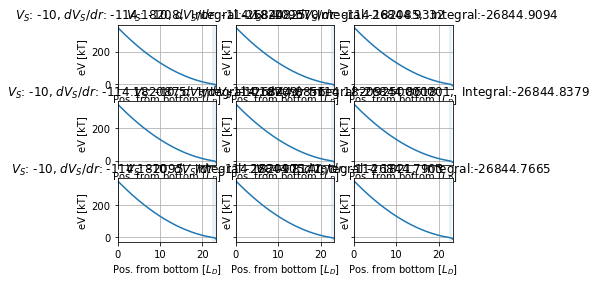

In [634]:
E_init_kT = -10
fig, axes = subplots(3,3, sharex=True, sharey=True)
#for i in linspace(0.85762405,0.85762407,5):
#for ax_i, (E_dot_init_kT) in enumerate(linspace(E_init_kT/np.e,E_init_kT*20, 9)):
for ax_i, (E_dot_init_kT) in enumerate(linspace(-114.18208,-114.1821, 9)):
    axe = fig.axes[ax_i]
    #E_dot_init_kT = (E_init_kT*i)
    
    #print(E_init_kT, E_dot_init_kT)
    E_init = mat.kT_to_J(E_init_kT)


    E_dot_init = mat.kT_to_J(E_dot_init_kT)
    print(E_init, E_dot_init)


    
    
    dF = pd.DataFrame(index = film.rs*1e9)

    r,v,v_dot,data = film.solve_with_values(E_init, E_dot_init)
    #v = film.material.kT_to_J(v)
    axe.plot(r,v)
    v_min = np.trapz(v[:np.argmin(np.abs(v))])
    print(v_min)
    axe.set_title(f"$V_S$: {E_init_kT}, $dV_S/dr$: {E_dot_init_kT},  Integral:{v_min:.4f}")
    #dF[E_dot_init_i]=v
        #axe.set_ylim(0,400)
    #dF.dropna().tail(4)
    #axe.set_yscale('log')
    axe.set_xlim(0,film.D/film.material.LD)
    int_space = r[:np.argmin(np.abs(v))]
    axe.axvspan(int_space[0],int_space[-1], alpha=0.1)
    #axe.set_ylim(-3,3)
    axe.set_ylabel(f'eV [kT]')
    axe.set_xlabel(f'Pos. from bottom [$L_D$]')
    axe.grid(b=True)

In [ ]:
if __name__ == '__main__':
    from pylab import *
    from plotHelper import *
    m = Material(T_C = 300)
   

    Delta_E_c_eV = -0.31
    Delta_E_c_eV = -m.Diff_EF_EC_evolt
    
    
    Delta_E_c = m.eV_to_J(Delta_E_c_eV)
    fermi_n = m.n(Delta_E_c)
    boltzm_n = m.n_boltzmann(Delta_E_c)
    boltzm_n_acc = m.n_boltzmann_acc(Delta_E_c)
    fermi_n = m.fermic_dirac(Delta_E_c)
    
    print('Fermi Proba.:',fermi_n)
    print('DEFC_eV:',m.Diff_EF_EC_evolt)
    print('Delta E_c_eV:',Delta_E_c_eV)

    print('Dept.:',boltzm_n/fermi_n-1)
    print('Acc.:',boltzm_n_acc/fermi_n-1)
    
    
    

    fig , axes = subplots(3)
    
    axe =axes[0]
    DVs_eV = np.linspace(0.5,-1.4)
    axe.set_xlim(0.5,-0.6)
    axe.set_ylim(0,3)
    DVs = m.eV_to_J(DVs_eV)
    print(DVs)
    
    fermi = m.fermic_dirac(DVs)
    boltz = m.boltzmann(DVs)
    axe.plot(DVs_eV,fermi, label='Fermi-Dirac')
    axe.plot(DVs_eV,boltz, label='Boltzmann')
    axe.set_ylabel('occupation probability')
    axe.set_xlabel('energy position relative to the conduction band[eV]')
    axe.vlines(-m.Diff_EF_EC_evolt,-10,100, linestyle='dashdot', label='Fermi-Energy')
    addUndublicatedLegend([axe], loc=2)
    
    
    axe =axes[1]
    axe.set_xlim(0.5,-0.6)
    axe.set_yscale('log')
    rel_error = (boltz-fermi)/fermi
    axe.set_ylabel('rel. error')
    axe.vlines(-m.Diff_EF_EC_evolt,-10,100000000, linestyle='dashdot', label='Fermi-Energy')
    axe.plot(DVs_eV, rel_error)
    axe.set_xlabel('energy position relative to the conduction band[eV]')
    addUndublicatedLegend([axe], labelAxe=axes[1], loc=2)
    #axe.hlines(0.5,-10,10)
    
    axe =axes[2]
    axe.set_yscale('log')
    #axe.set_xlim(0.5,-0.6)
    axe.set_xlim(-0.2,-1.2)
    #axe.vlines(-EDFC/e_charge,1e10,1e30, linestyle='dashdot', label='Fermi-Energy')
    n_boltz = m.n_boltzmann(DVs)
    n_boltz_acc = m.n_boltzmann_acc(DVs)
    nc_fermi = m.NC*m.fermic_dirac(DVs)
    axe.plot(DVs_eV,n_boltz*10**-6, label='Boltzmann')
    #axe.plot(DVs_eV,nc_fermi, label='$N_C*Fermi$')
    n_fermi = []
    for DV in DVs:
        n_fermi.append(m.n(DV))
    n_fermi = np.array(n_fermi)
    error = (n_boltz-n_fermi)/n_fermi*100.0
    error_acc= (n_boltz_acc-n_fermi)/n_fermi*100.0
    axe.plot(DVs_eV,n_fermi*10**-6, label='Fermi Integral')
    axe_error = axe.twinx()
    axe_error.set_yscale('log')
    
    
    #axe_error.set_xlim(0.5,-0.6)
    axe_error.set_xlim(-0.2,-1.2)
    
    
    axe_error.set_ylabel('rel. error [%]')
    #axe_error.plot(DVs_eV, error, 'b--', label='error $N_C*Fermi$ vs. Int-Fermi')
    axe_error.plot(DVs_eV, error, 'b--', label='error Boltzmann vs. Fermi-Integral')
    axe.set_xlabel('energy position relative to the conduction band[eV]')
    addUndublicatedLegend([axe, axe_error], labelAxe=axes[2], loc=2)
    
    
    
    
    
    fig, axe = subplots()
    
    axe.set_yscale('log')
    axe.set_xlim(-0.2,-1.2)


    axe.plot(DVs_eV,n_fermi*10**-6, 'r' ,label='Fermi Integral', linewidth=10)
    axe_error = axe.twinx()
    axe_error.set_yscale('log')
    axe.plot(DVs_eV,n_boltz_acc*10**-6, 'k', label=r'$n = n_b*exp(\frac {eV_S} {2k_BT})$ (Boltzmann acc.)')
    axe.plot(DVs_eV,n_boltz*10**-6, 'b', label=r'$n = n_b*exp(\frac {eV_S} {k_BT})$ (Boltzmann)')
    
    
    fs = 18
    axe.set_ylabel('$n(E_{V_S})[cm^3]$', fontsize=fs)
    #axe_error.set_xlim(0.5,-0.6)
    axe_error.set_xlim(-0.2,-1.2)
    axe_error.set_xlim(-1.5,-0.2)
    axe_error.set_ylim(1e-4,1e4)
    #axe.set_ylim(10**17,10**23)
    
    title = '$At \/'+'{:0.0f}'.format(m.T_C)+'^{\circ}C \/ and \/' + '(E_{C_0} - E_F) = '+str(round(m.Diff_EF_EC_evolt, 2))+'eV  \/ $'
    axe.set_title(title,fontsize = fs)
    axe.axvspan(m.J_to_eV(-m.Diff_EF_EC-m.kT), m.J_to_eV(-m.Diff_EF_EC+m.kT))
    
    
    axe.annotate('Fermi level pos.', xy=(-m.Diff_EF_EC_evolt, 10**25), xytext=(0.5,.8),
                arrowprops=dict(facecolor='black', shrink=0.05),fontsize=fs, textcoords='axes fraction',
                )
    
    axe_error.set_ylabel('rel. error [%]', fontsize=fs)
    #axe_error.plot(DVs_eV, error, 'b--', label='error $N_C*Fermi$ vs. Int-Fermi')
    axe_error.plot(DVs_eV, error, '--', label='error Boltzmann vs. Int-Fermi')
    axe_error.plot(DVs_eV, error_acc, '--', label='error Boltzmann acc. vs. Int-Fermi')
    axe.set_xlabel('energy position relative to the initial conduction band[eV]',fontsize=fs)
    addUndublicatedLegend([axe, axe_error], legendSize=fs/1.5)

In [16]:
import Material
import Constants

In [32]:
mat = Material.Material(-200)
mat.Diff_EF_EC/mat.kT

3.317152141500683

# Define the fuunctions, as shown in the paper.
All const are set to 1

In [10]:
E_F = 0 
E_C = 3
def g_c(E,E_C):
    return 4*2**(3/2)*(E-E_C)**0.5
def f(E):
    return 1/(1+np.exp(E-E_F))

def n_0_full(E_C):
    n_0,n_0_error = integrate.quad(lambda E:g_c(E,E_C)*f(E), E_C, E_C+np.inf) #the factor 100 should be inf, but shown in the lower cell, that 100 is ok
    return n_0, n_0_error

def n_0_bolz(E_C):
    return 2*2**(3/2)*np.exp(-(E_C-E_F))

# Integration bounds
- the inetragtion to calc. $n_0$ afre from $E_C$ to inf.
- Do we need the upper as inf?
- check here if a high value is enought. Here in the example we check a high level of 100kT -> $E_C$+100kT

In [11]:
n_0_s = []
upper_lims = []
E_C = 3
for x in linspace(0,100, 50):
    n_0 = integrate.quad(lambda E:g_c(E,E_C)*f(E), E_C, E_C+x)
    n_0_s.append(n_0[0])
    upper_lims.append(x)
    

### Plot the integration bounds limits

100 is cool.


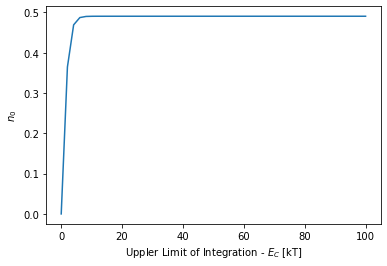

In [12]:
close()
fig, axe = subplots()
axe.plot(upper_lims, n_0_s)
axe.set_xlabel('Uppler Limit of Integration - $E_C$ [kT]')
axe.set_ylabel('$n_0$')
print('100 is cool.')

 Looks like a 100kT upper limit should be enough.

## Check the $n_0$ for multiple $E_C$ positions in relation to the $E_F$ in units of $kT$

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


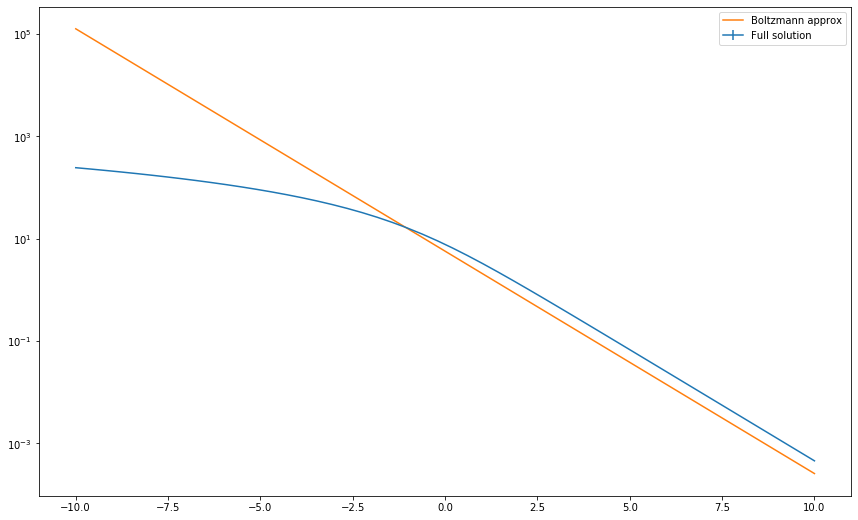

In [13]:
n_0_s = []
n_0_boltz_s = []
n_0_s_err = []
E_Cs = []
for E_C in linspace(-10,10):
    res = n_0_full(E_C)
    n_0_s.append(res[0])
    n_0_s_err.append(res[1])
    E_Cs.append(E_C)
    n_0_boltz_s.append(n_0_bolz(E_C))
    
fig, axe = subplots(figsize = ((1+5**0.5)/2*9,9))
axe.errorbar(E_Cs, n_0_s, yerr=n_0_s_err, fmt='-', label='Full solution')
axe.plot(E_Cs, n_0_boltz_s, '-', label='Boltzmann approx')
axe.legend()
axe.set_yscale('log')